# Importing Necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU active! - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Importing Dataset


* CN (Cognitively Normal): Individuals without cognitive impairment.
* MCI (Mild Cognitive Impairment): Individuals with a subtle decline in cognitive abilities that may or may not progress to more severe conditions.
* LMCI (Late Mild Cognitive Impairment): A stage within the MCI category, typically representing a later or more advanced phase of mild cognitive impairment.
* EMCI (Early Mild Cognitive Impairment): Another stage within the MCI category, indicating an earlier or less advanced phase of mild cognitive impairment.


There are 3200 images in the CN folder.
There are 896 images in the MCI folder.
There are 2250 images in the EMCI folder.
There are 946 images in the LMCI folder.
The search has been completed.


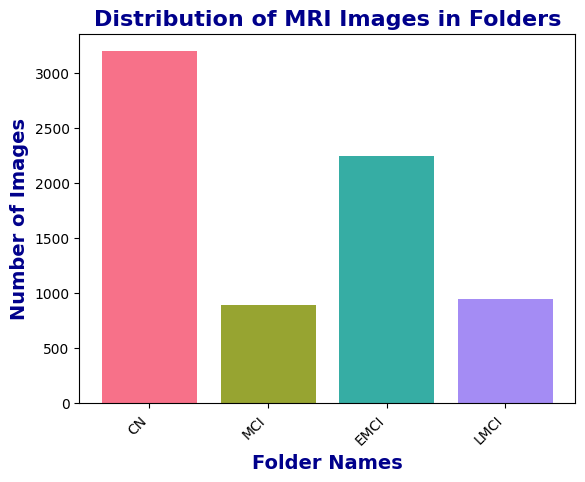

In [ ]:
folder_path = '/content/drive/MyDrive/Capstone/MRI'
class_dist = {}
image_extensions = ['.jpg', '.jpeg', '.png']

def count_images_in_folder(dir_path):
    count = 0
    for filename in os.listdir(dir_path):
        file_ext = os.path.splitext(filename)[1].lower()

        if file_ext in image_extensions:
            count += 1
    return count

def analyze_folder_structure():
    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = count_images_in_folder(dir_path)
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m' + "The search has been completed." + '\033[0m')

def plot_distribution_bar_chart():
    keys = list(class_dist.keys())
    values = list(class_dist.values())

    colors = sns.color_palette("husl", len(keys))

    plt.bar(keys, values, color=colors)
    plt.xlabel('Folder Names', fontsize=14, fontweight="bold", color="darkblue")
    plt.ylabel('Number of Images', fontsize=14, fontweight="bold", color="darkblue")
    plt.title('Distribution of MRI Images in Folders', fontsize=16, fontweight="bold", color="darkblue")
    plt.xticks(rotation=45, ha='right')
    plt.show()

analyze_folder_structure()
plot_distribution_bar_chart()


<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Let's see some samples for each class!</p>

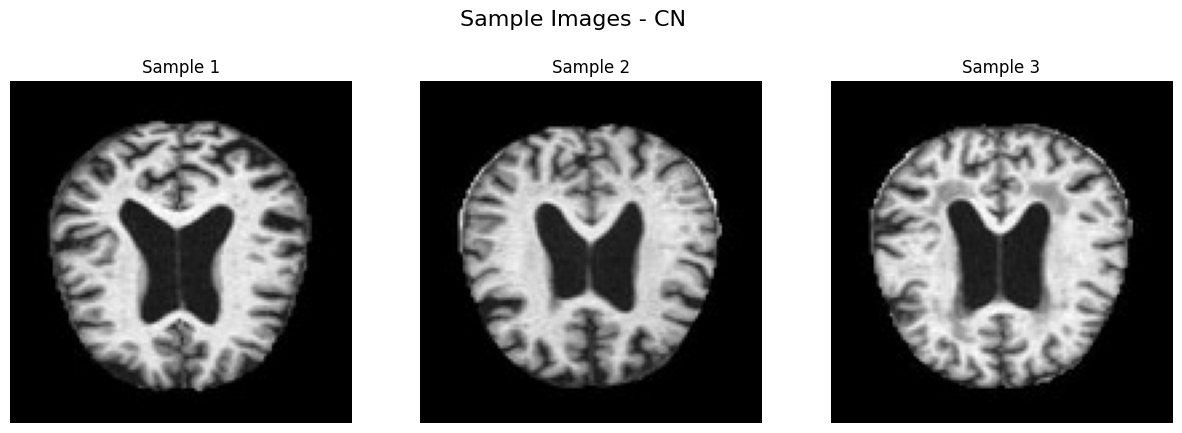

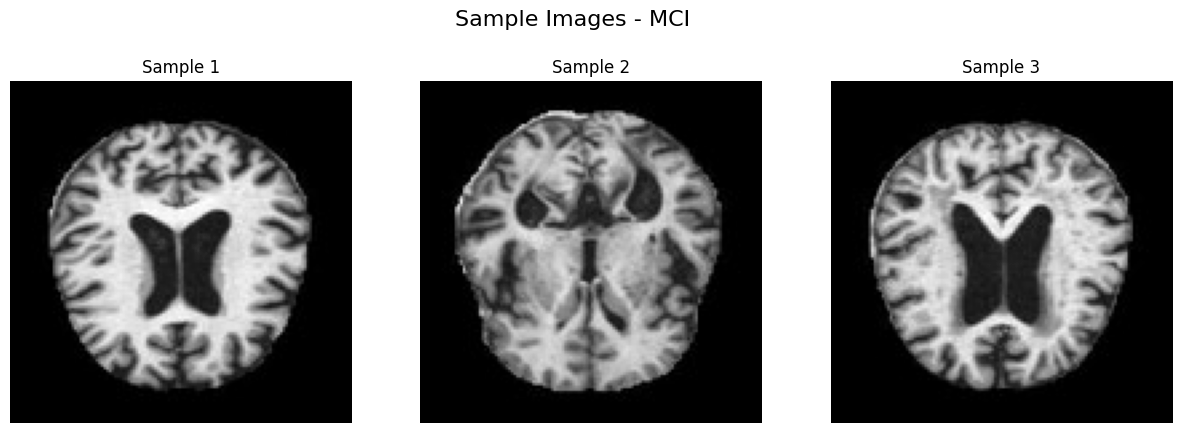

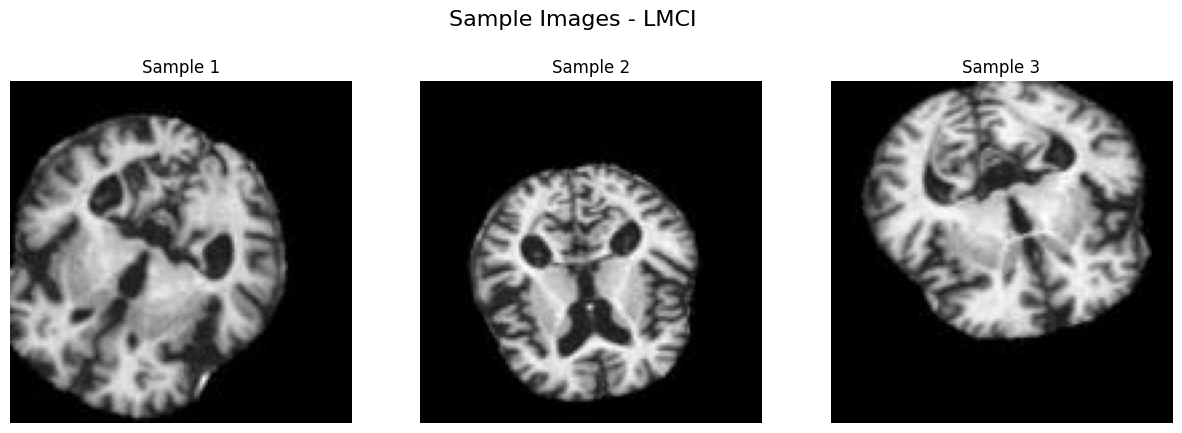

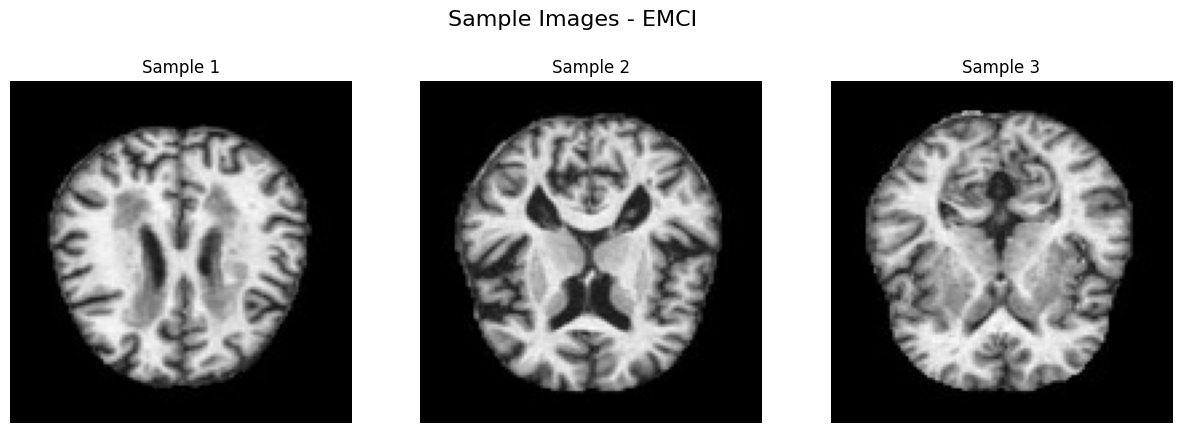

In [ ]:
base_path = '/content/drive/MyDrive/Capstone/MRI'
categories = ['CN', 'MCI', 'LMCI', 'EMCI']
def display_sample_images(category, num_images=3):
    category_path = os.path.join(base_path, category)
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(image_files, num_images)
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(category_path, image_name)
        image = Image.open(image_path)

        plt.subplot(1, num_images, i+1)
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.title(f'Sample {i+1}')
        plt.axis('off')

    plt.suptitle(f'Sample Images - {category}', fontsize=16)
    plt.show()
for category in categories:
    display_sample_images(category)


# Data Preprocessing

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(base_path,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = dataset.class_names

Found 7292 files belonging to 4 classes.


<p style="color: black; background-color: lightsteelblue; border:2px solid black;">Pixel normalization improves the performance of a neural network. Therefore, we will go with pixel values from 0 to 1, rather than values in the range 0 to 255.</p>

In [ ]:
MRI = {index: img for index, img in enumerate(dataset.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI Samples in the Batch", color="blue",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(MRI[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


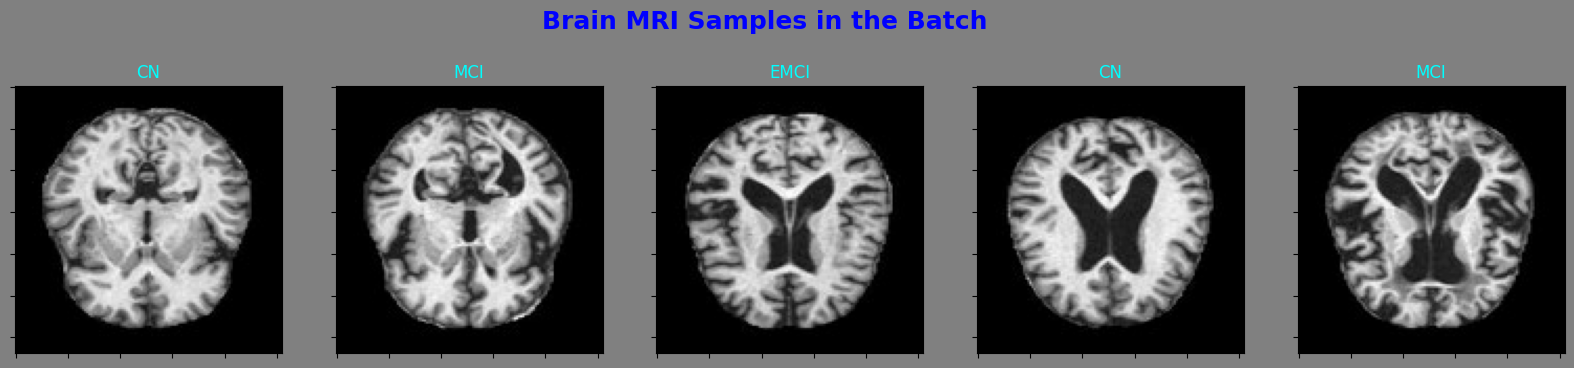

In [ ]:
df = Process(dataset)
df.create_new_batch()
df.show_batch_images(number_of_images=5)

# Splitting the Data

In [ ]:
train_data, val_data, test_data= df.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

#### Preprocessing the Training set

To address the imbalanced distribution of target classes in our training data, we calculate class weights, which help the model better recognize minority classes, and then use these weights during model training for improved performance.

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building Resnet

In [ ]:
from tensorflow.keras import layers, Model

def build_resnet_model():
    input_tensor = layers.Input(shape=(128, 128, 3))

    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_tensor)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    output_tensor = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

def residual_block(x, filters, downsample=False):
    shortcut = x

    x = layers.Conv2D(filters, (3, 3), strides=(2 if downsample else 1, 2 if downsample else 1),
                      padding='same', activation='relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    if downsample:
        shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding='valid')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

model = build_resnet_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['max_pooling2d[0][0]']   

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Callbacks</h2>

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 30
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/30
182/182 [==============================] - ETA: 0s - loss: 1.3630 - accuracy: 0.2962
Epoch 1: val_accuracy improved from -inf to 0.40909, saving model to /tmp/checkpoint
182/182 [==============================] - 294s 2s/step - loss: 1.3630 - accuracy: 0.2962 - val_loss: 1.1934 - val_accuracy: 0.4091
Epoch 2/30
182/182 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.4176
Epoch 2: val_accuracy improved from 0.40909 to 0.43182, saving model to /tmp/checkpoint
182/182 [==============================] - 43s 232ms/step - loss: 0.9825 - accuracy: 0.4176 - val_loss: 1.0573 - val_accuracy: 0.4318
Epoch 3/30
182/182 [==============================] - ETA: 0s - loss: 0.9372 - accuracy: 0.4358
Epoch 3: val_accuracy did not improve from 0.43182
182/182 [==============================] - 40s 214ms/step - loss: 0.9372 - accuracy: 0.4358 - val_loss: 1.0503 - val_accuracy: 0.2244
Epoch 4/30
182/182 [==============================] - ETA: 0s - loss: 0.8966 - accuracy:

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

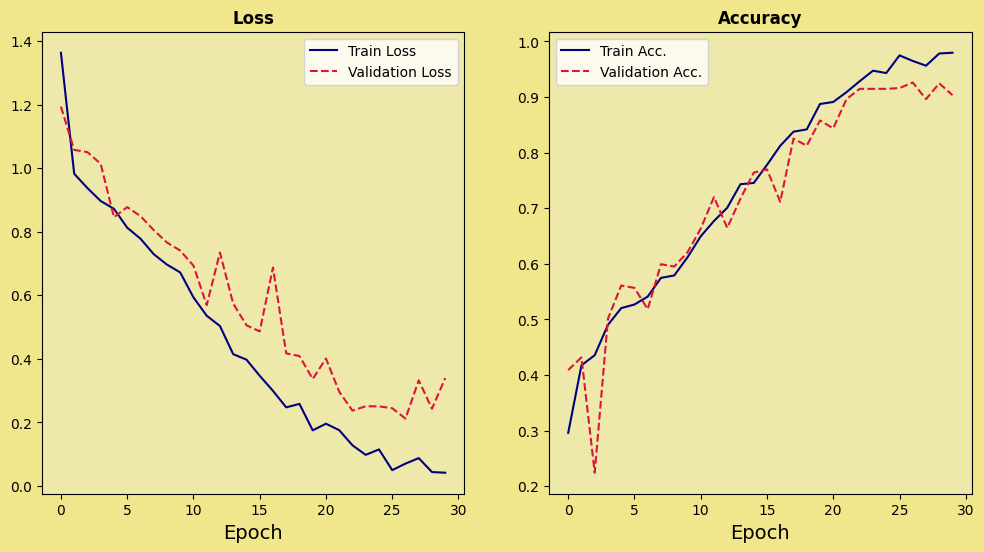

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Capstone', 'resnet_model.h5'))
print("Model saved successfully after training!")

Model saved successfully after training!


# Resnet Model Testing

In [ ]:
from tensorflow.keras.models import load_model

saved_model_path = '/content/drive/MyDrive/Capstone/resnet_model.h5'
resnet_model = load_model(saved_model_path)

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Classification Report</h2>

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = resnet_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

          CN       0.87      0.96      0.91       297
        EMCI       0.91      0.72      0.80       216
        LMCI       0.90      1.00      0.95        96
         MCI       0.86      0.87      0.86        95

    accuracy                           0.88       704
   macro avg       0.88      0.89      0.88       704
weighted avg       0.88      0.88      0.88       704



<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Confusion Matrix</h2>

Text(287.16666666666663, 0.5, 'True')

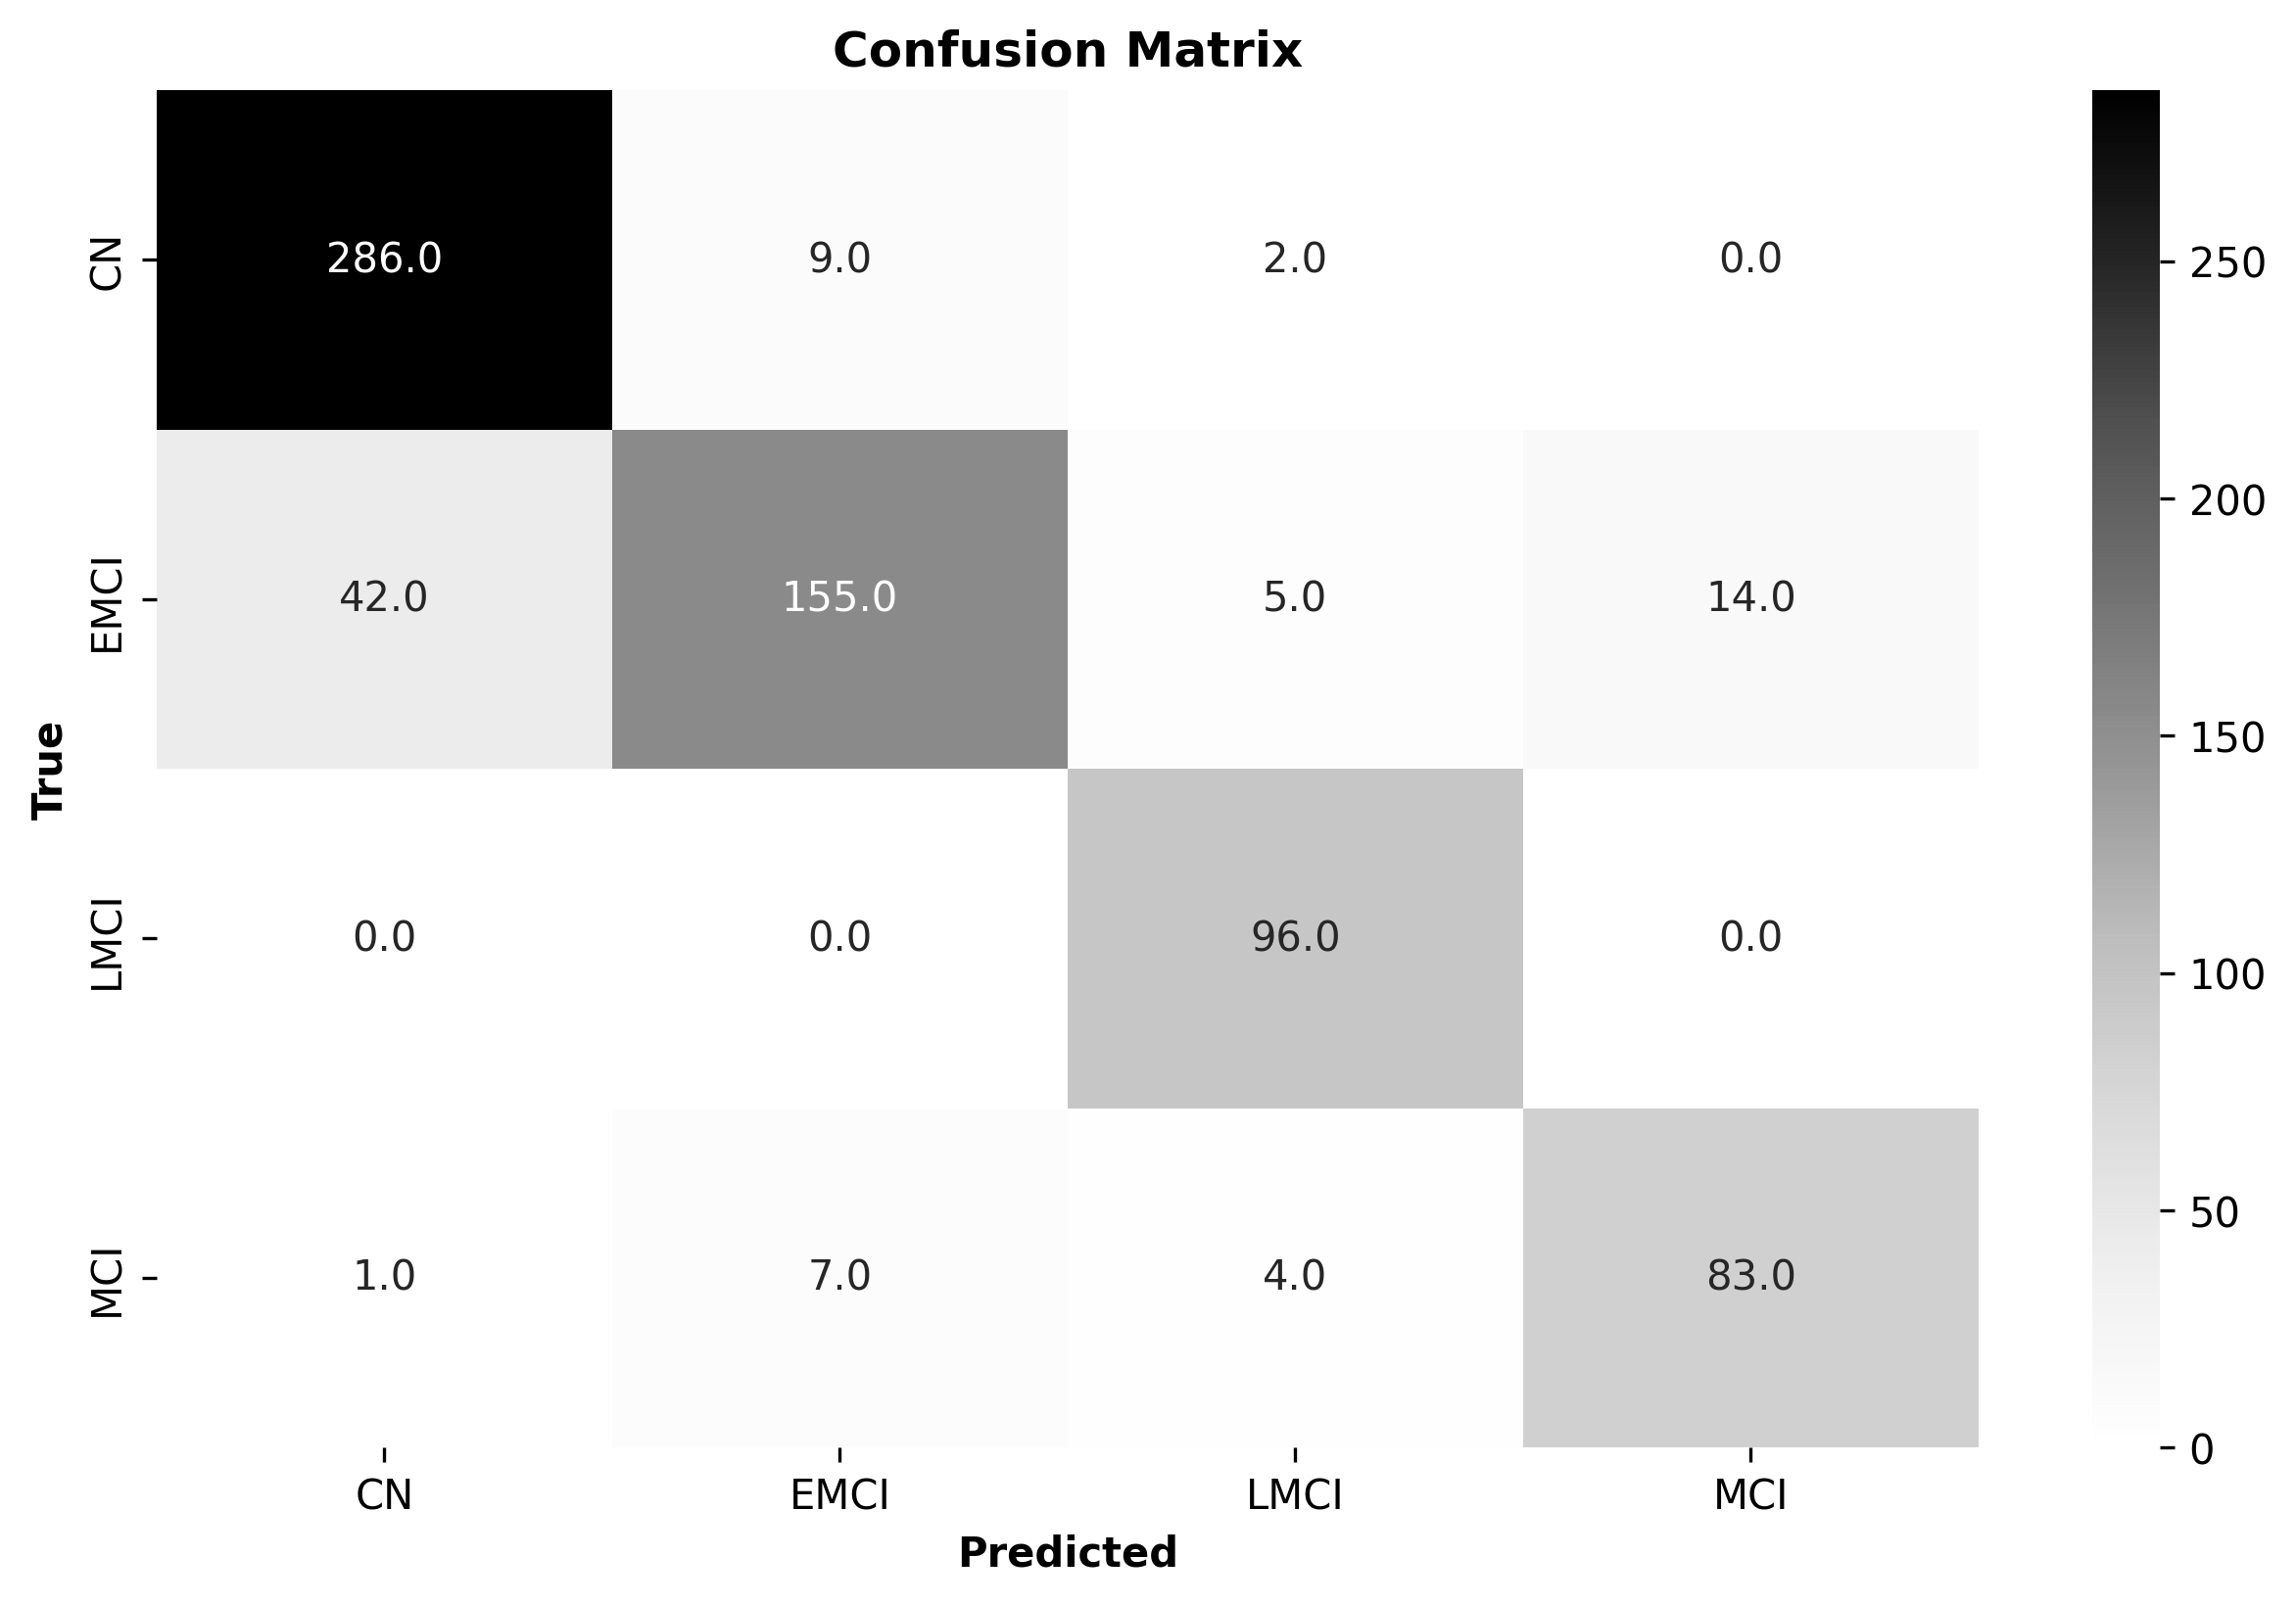

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Let's create a function that fetches a random image and displays a pie chart showing the probability distribution of which target value the image belongs to, represented as percentages. In this way, it will be seen which class the model gives the highest probability to.</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Cognitive Probability of a Random MRI from Test Data</h2>

1/1 [==============================] - 1s 787ms/step


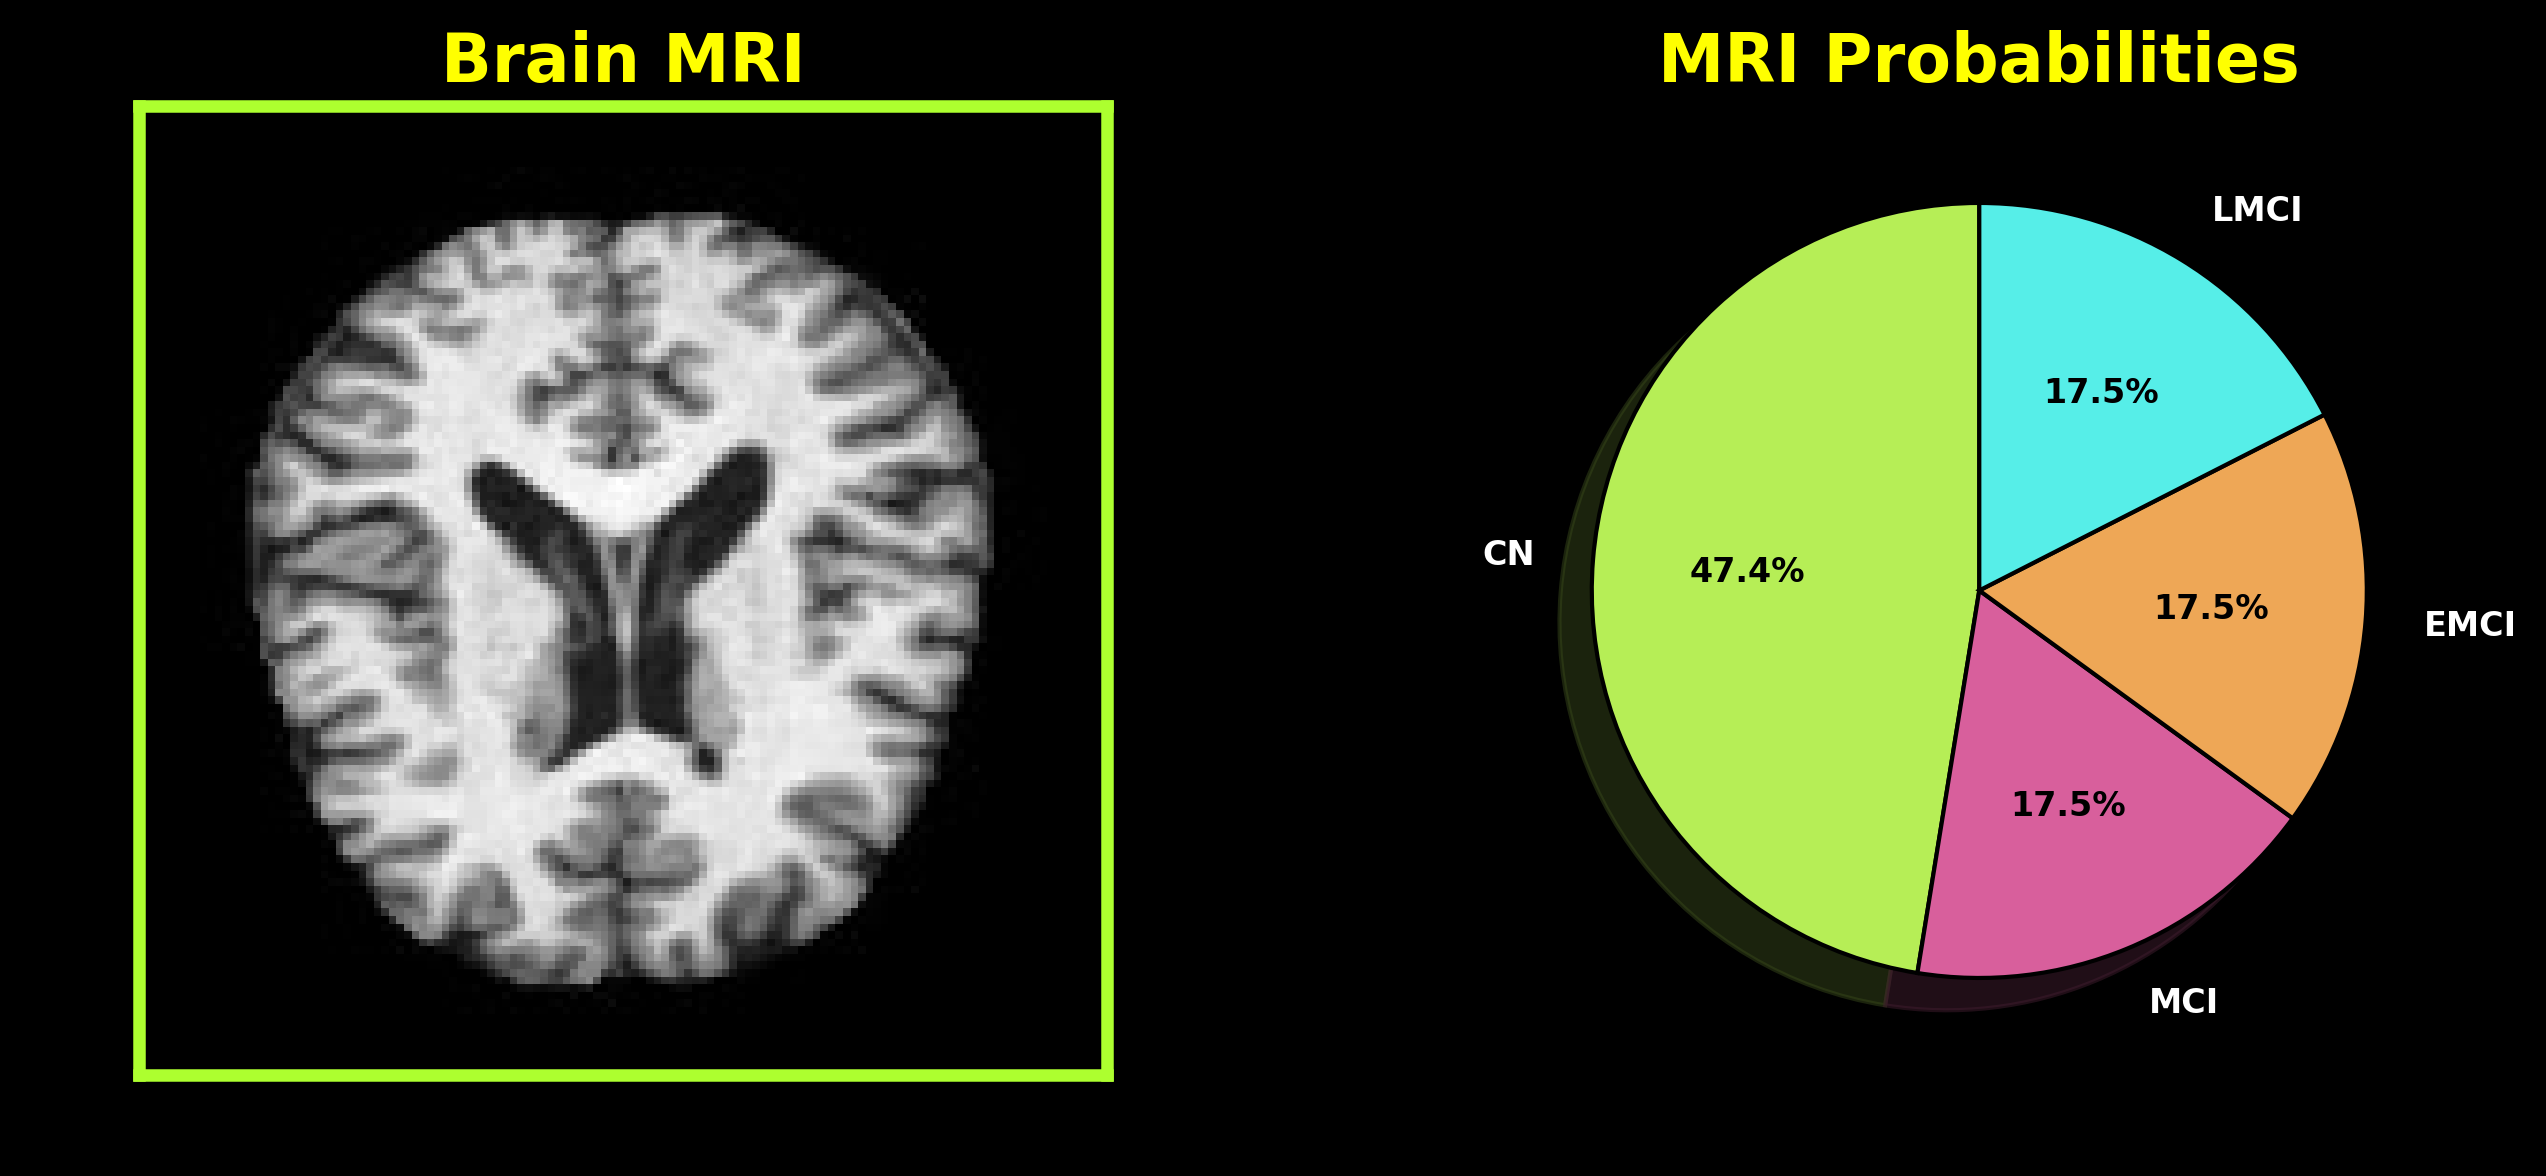

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = resnet_model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('MRI Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

<p style="color: black; background-color: lightsteelblue; border:2px solid black;">
Now, let's see the actual classes and predicted classes of these samples by bringing samples from our test data.</p>

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Comparing Predicted Classes with the Actual Classes from the Test Data</h2>

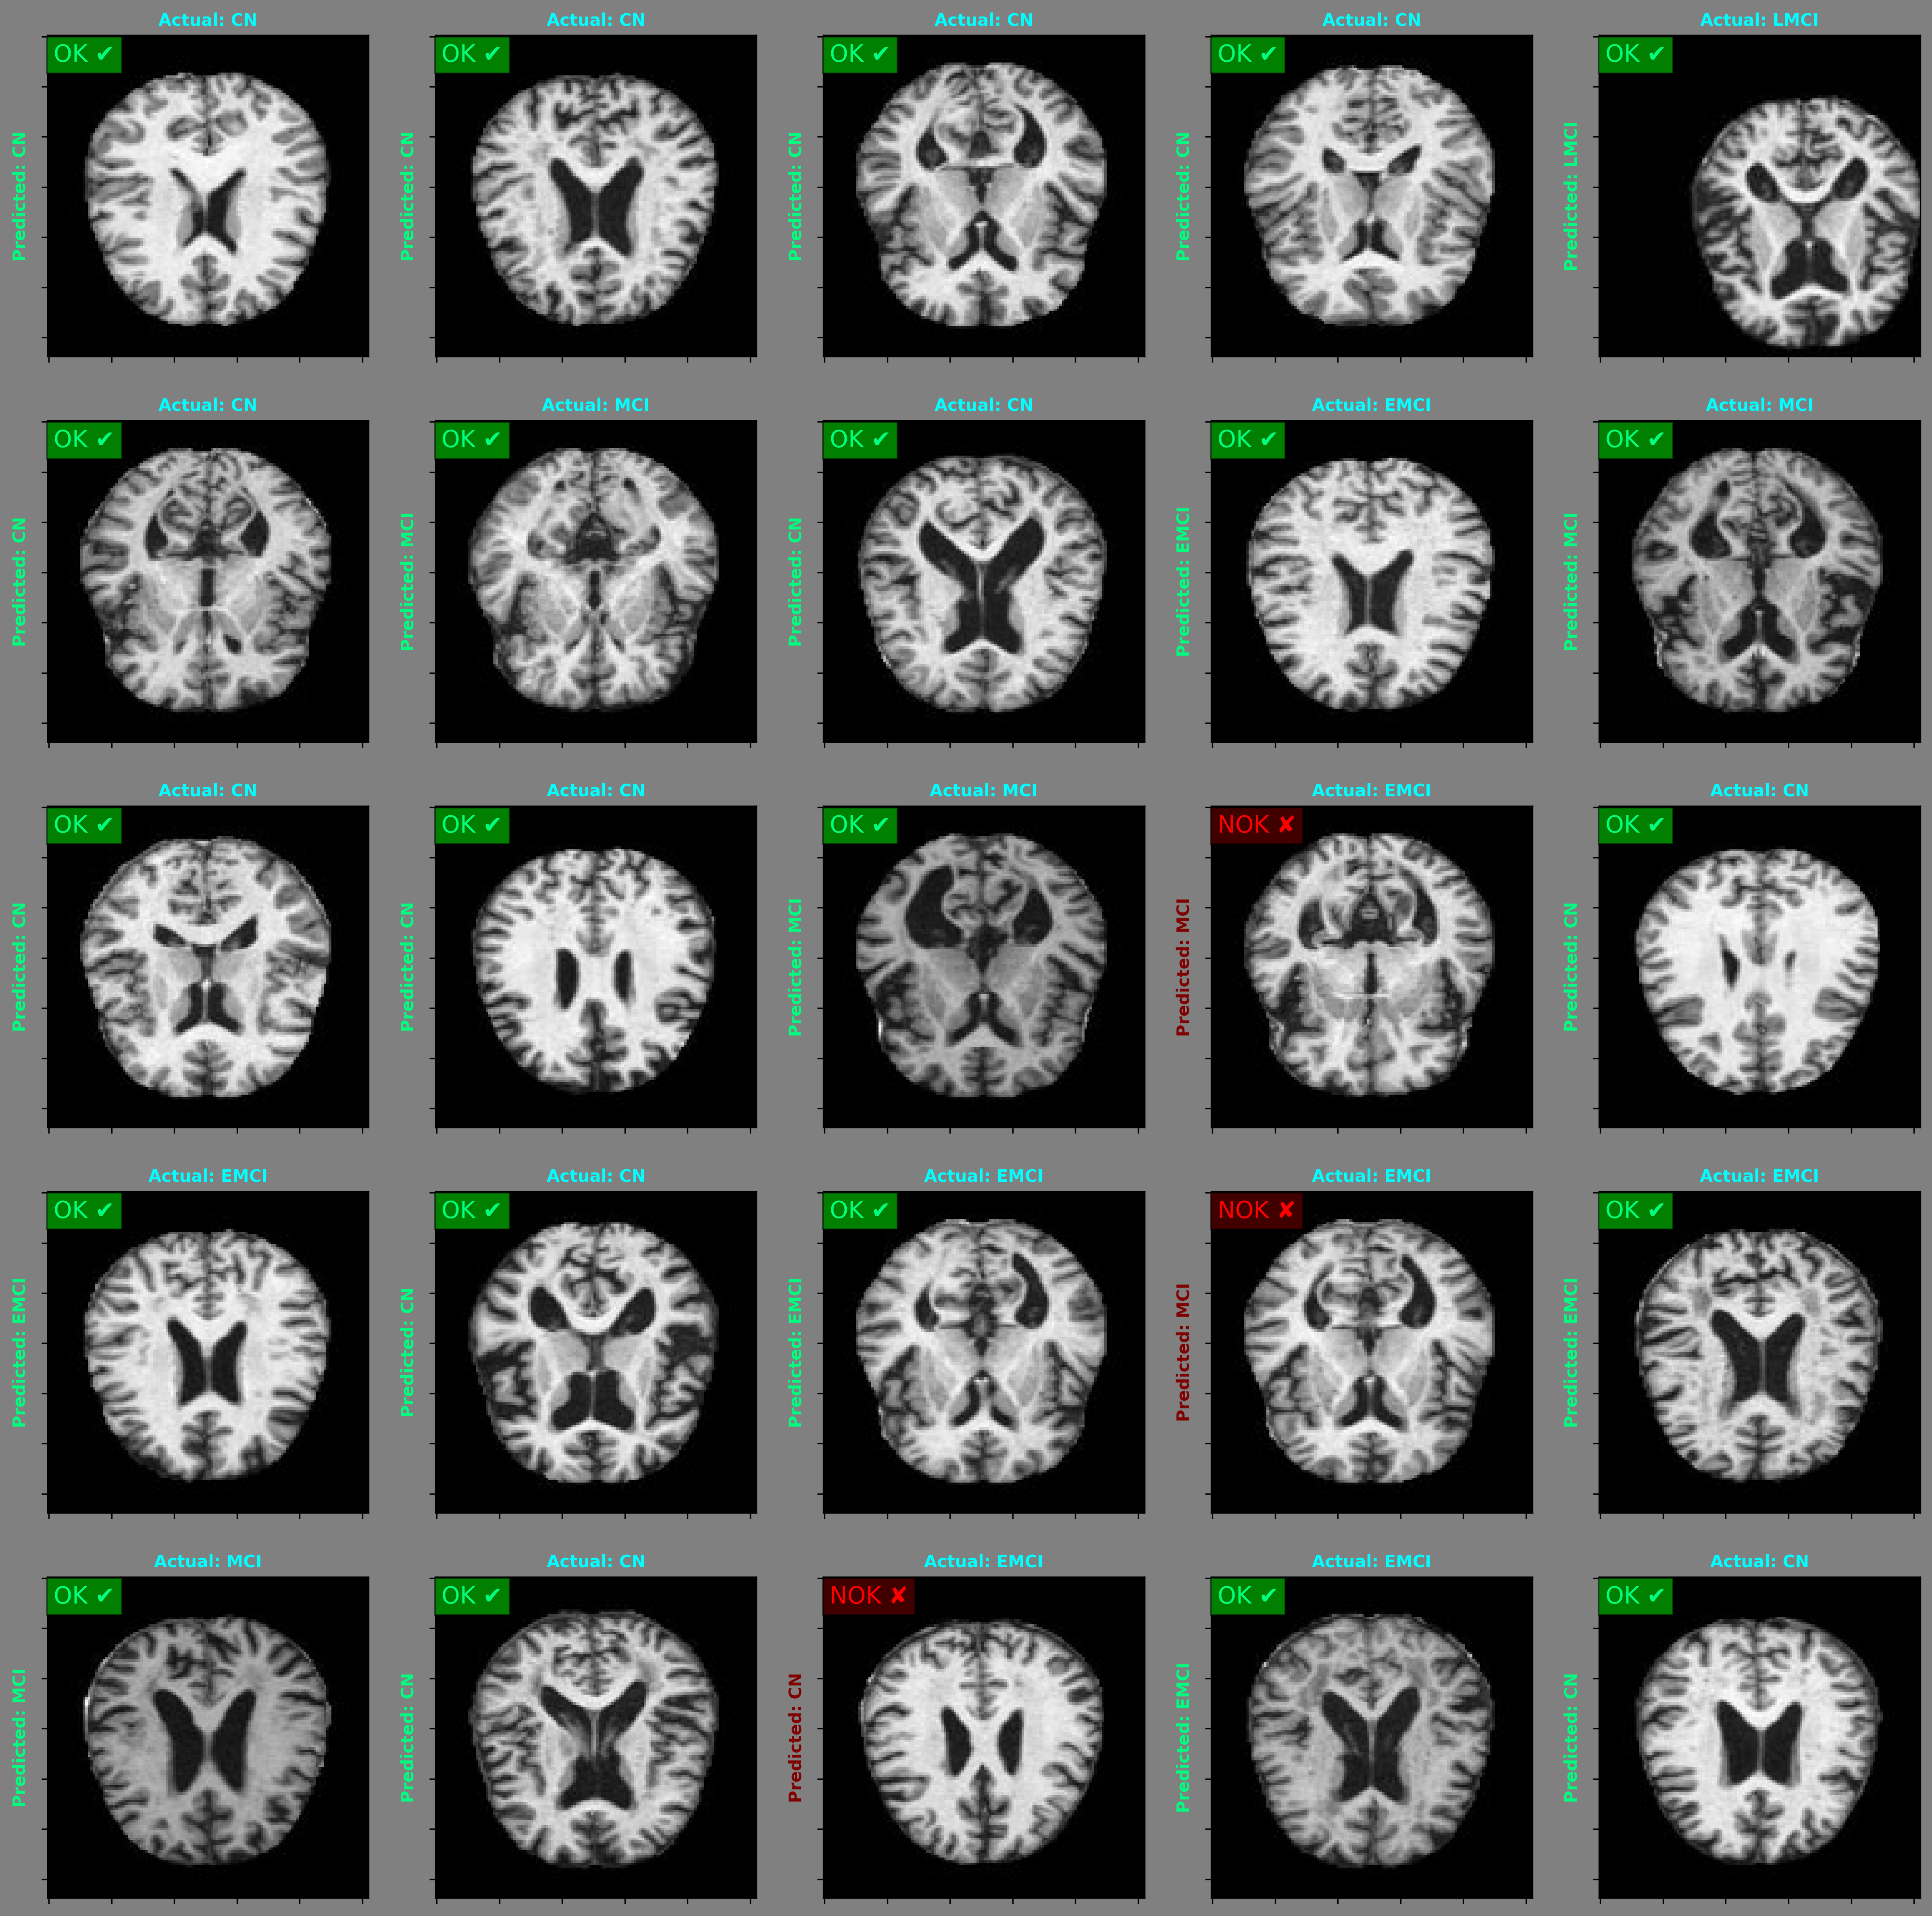

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = resnet_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

# Model Building VGG16 and Testing

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16

def build_vgg_model():
    input_tensor = layers.Input(shape=(128, 128, 3))

    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output_tensor = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_tensor)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = build_vgg_model()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                            

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=8)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 1.4663 - accuracy: 0.4626
Epoch 1: val_accuracy improved from -inf to 0.55824, saving model to /tmp/checkpoint
182/182 [==============================] - 46s 215ms/step - loss: 1.4663 - accuracy: 0.4626 - val_loss: 0.9051 - val_accuracy: 0.5582
Epoch 2/20
182/182 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.4928
Epoch 2: val_accuracy did not improve from 0.55824
182/182 [==============================] - 38s 206ms/step - loss: 0.8894 - accuracy: 0.4928 - val_loss: 0.8759 - val_accuracy: 0.5440
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.8814 - accuracy: 0.4311
Epoch 3: val_accuracy did not improve from 0.55824
182/182 [==============================] - 38s 208ms/step - loss: 0.8814 - accuracy: 0.4311 - val_loss: 1.0005 - val_accuracy: 0.3991
Epoch 4/20
182/182 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.3951
Epoch 4: val_accuracy impro

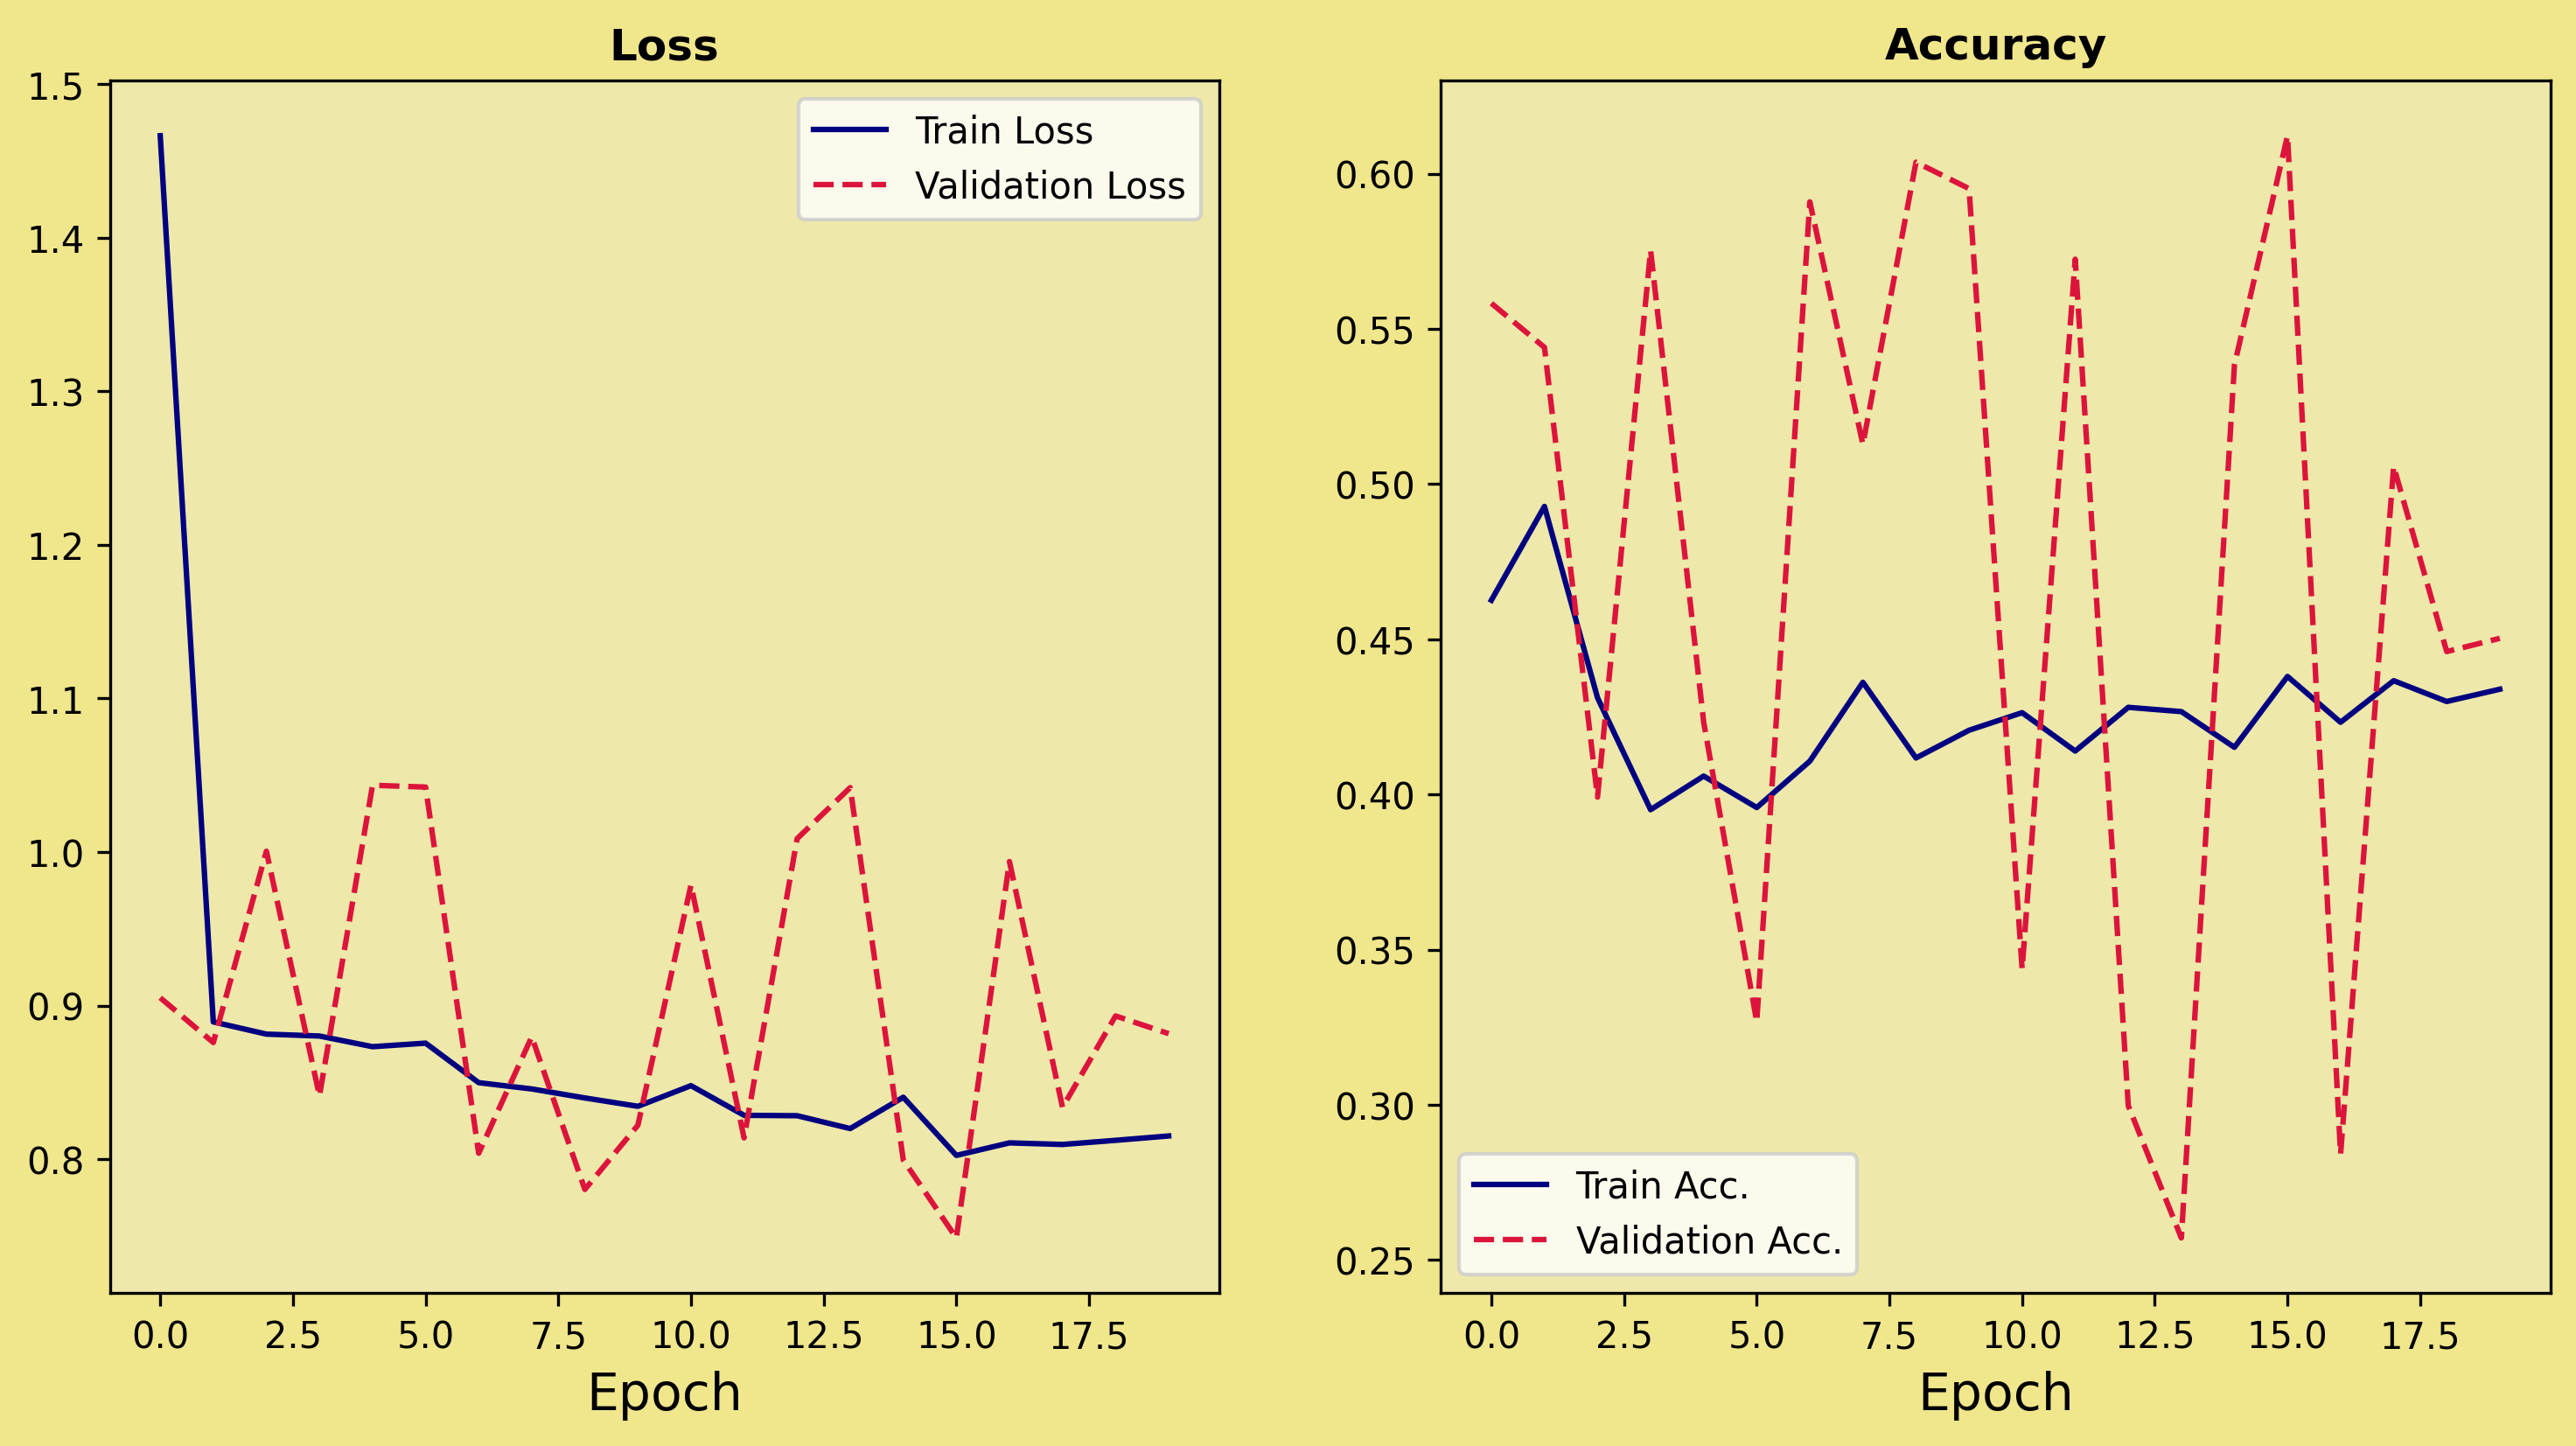

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Capstone', 'vgg_model.h5'))
print("Model saved successfully after training!")

Model saved successfully after training!


In [ ]:
saved_model_path = '/content/drive/MyDrive/Capstone/vgg_model.h5'
vgg_model = load_model(saved_model_path)

In [ ]:
vgg_model.evaluate(test_data)

22/22 [==============================] - 21s 98ms/step - loss: 0.8852 - accuracy: 0.4602


[0.885235071182251, 0.46022728085517883]

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = vgg_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

          CN       1.00      0.01      0.02       308
        EMCI       0.35      0.75      0.48       213
        LMCI       1.00      0.92      0.96        93
         MCI       0.44      0.79      0.56        90

    accuracy                           0.45       704
   macro avg       0.70      0.62      0.51       704
weighted avg       0.73      0.45      0.35       704



Text(287.16666666666663, 0.5, 'True')

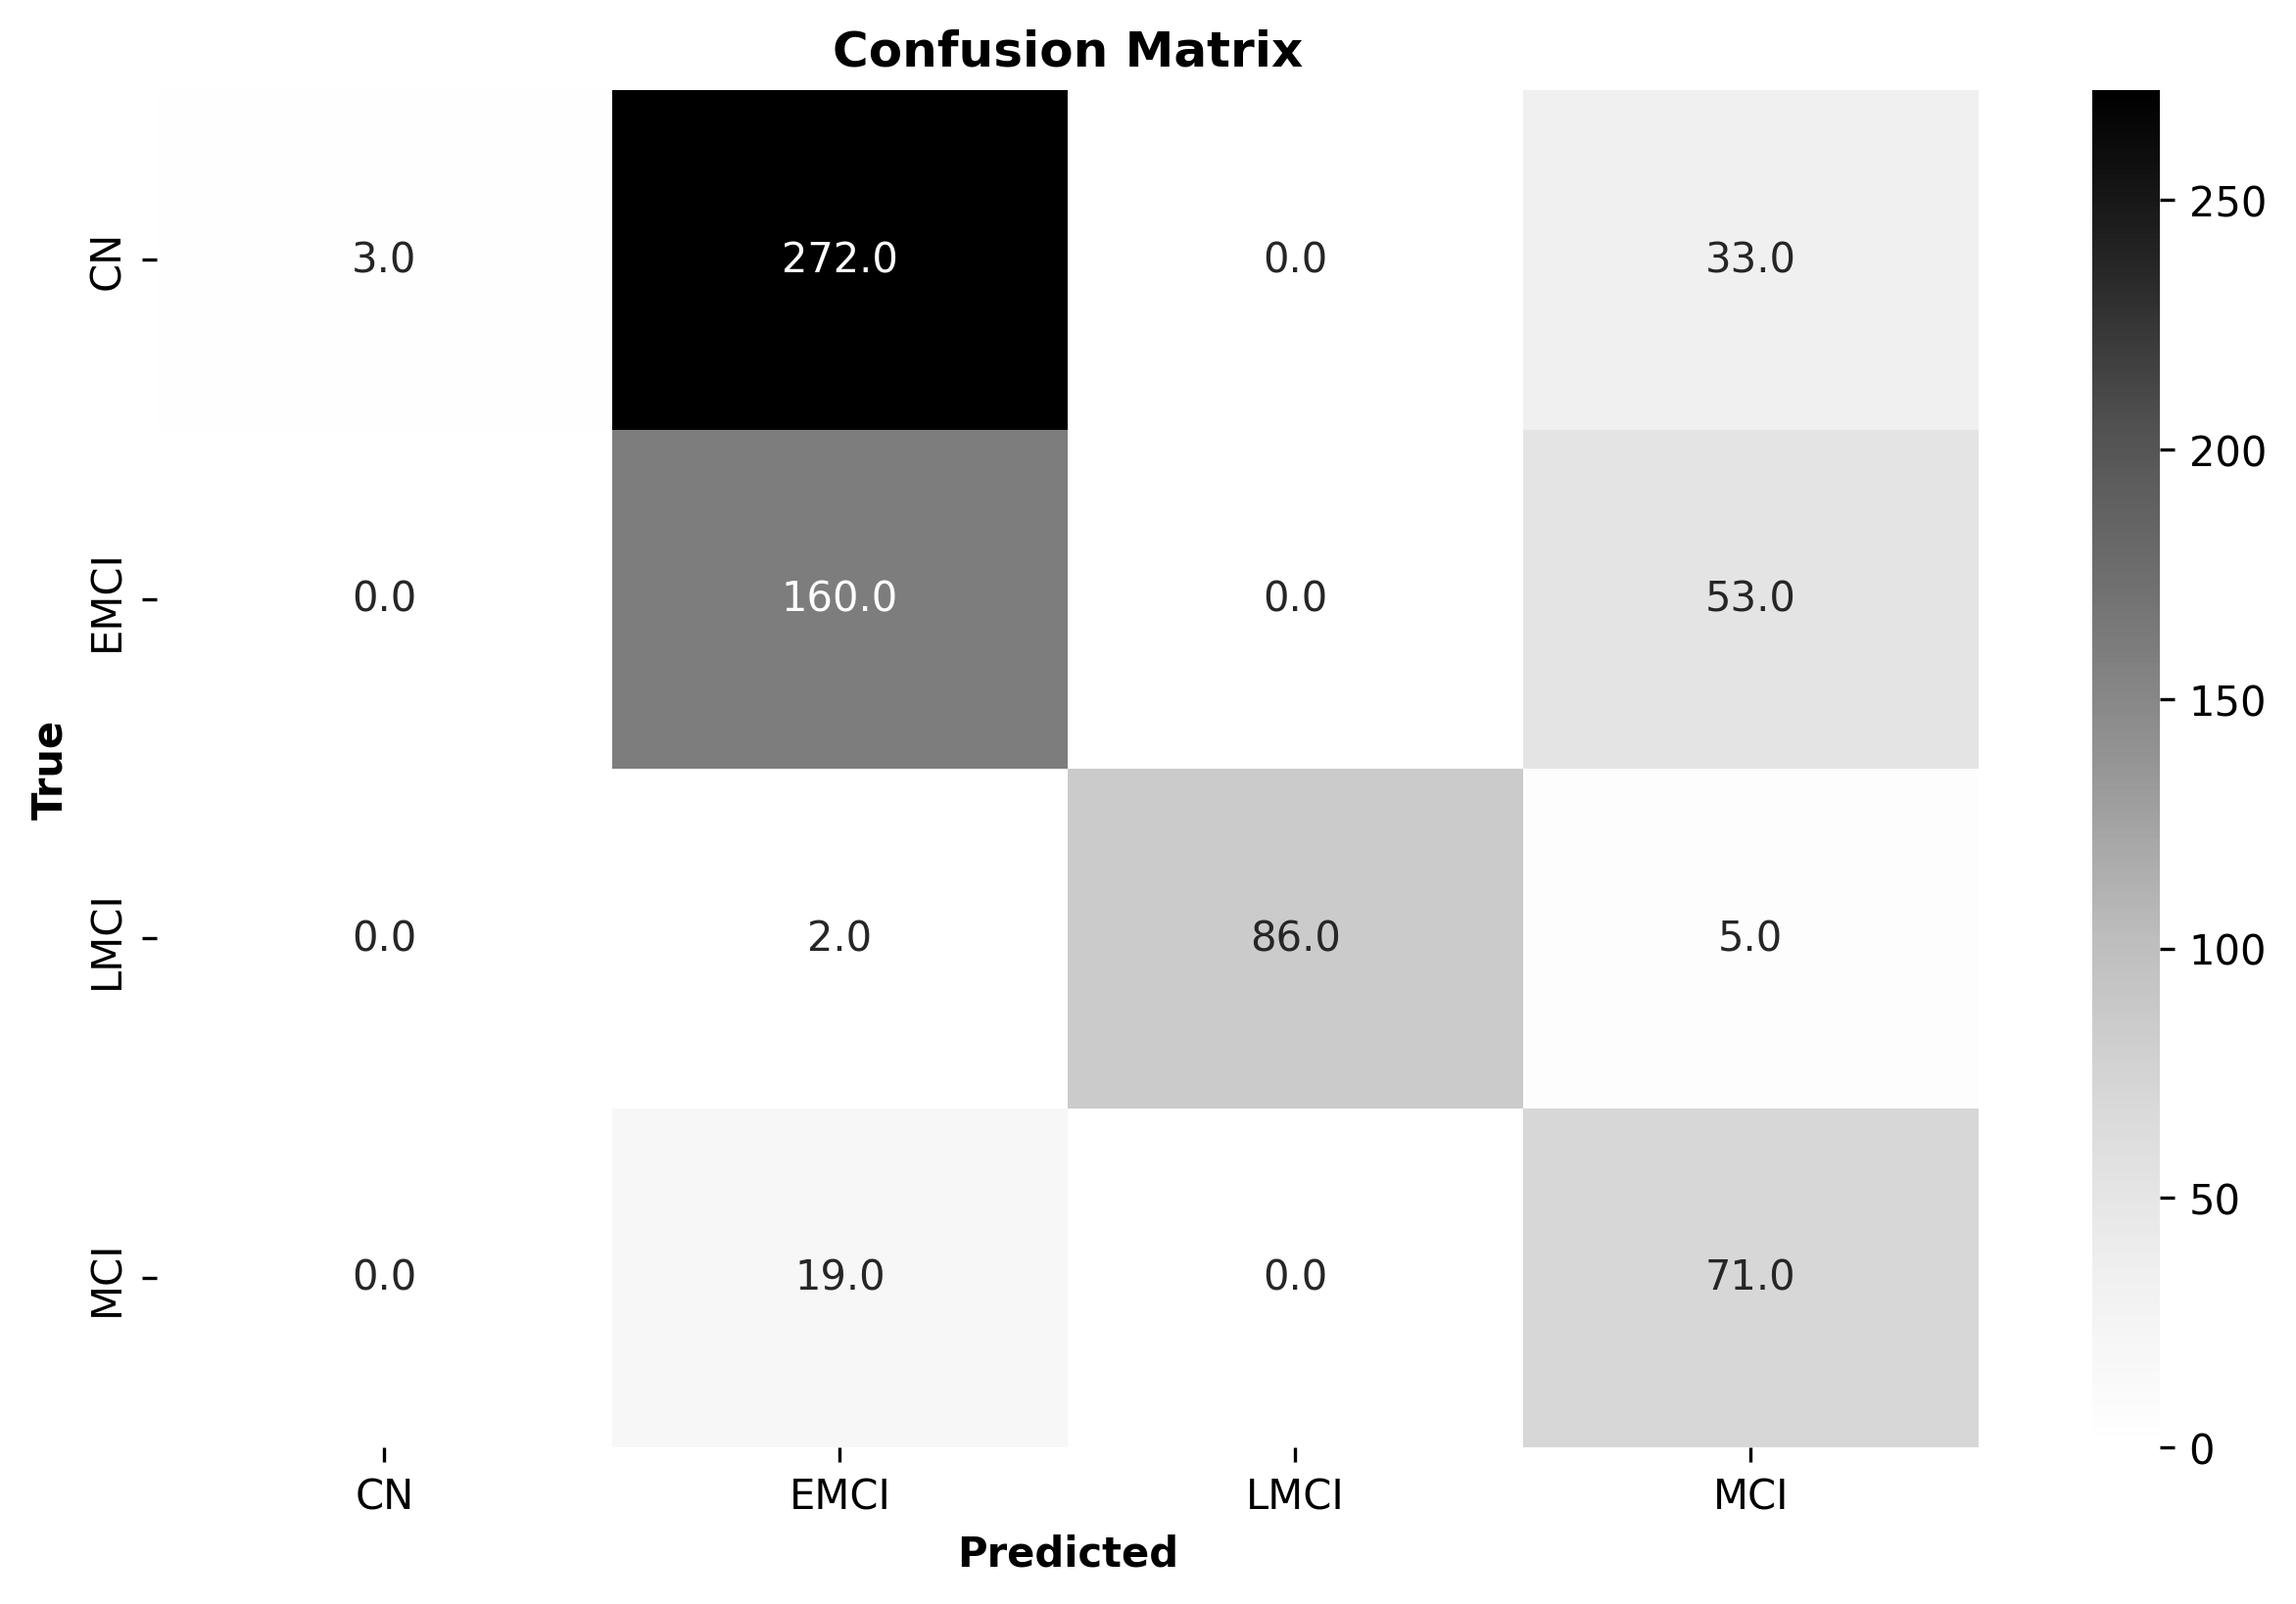

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

1/1 [==============================] - 1s 1s/step


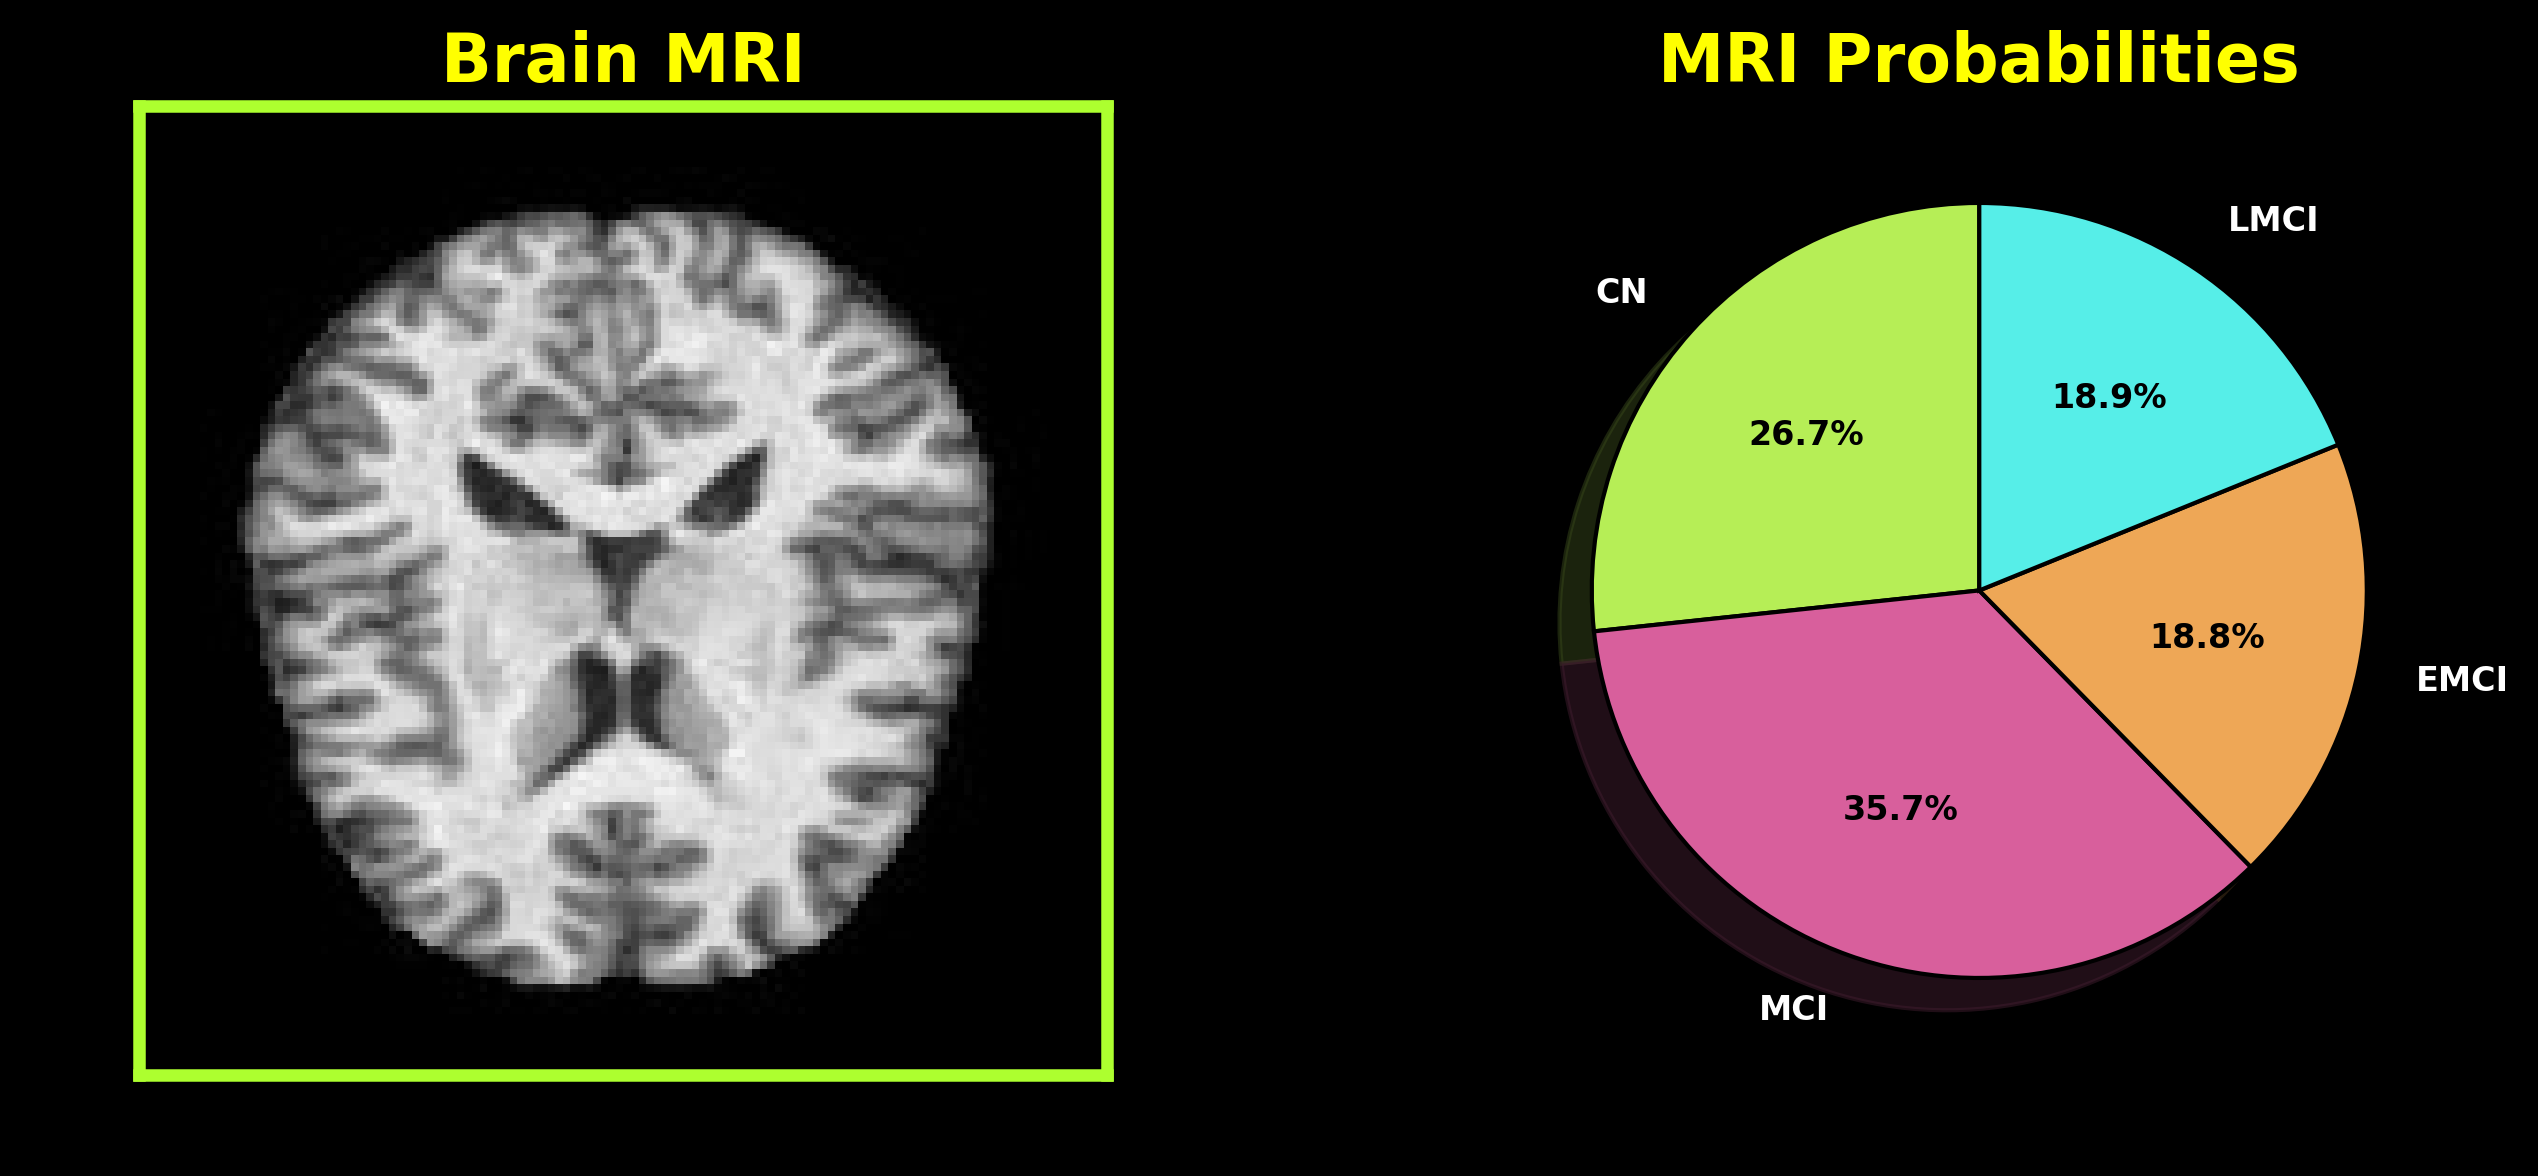

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = vgg_model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('MRI Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

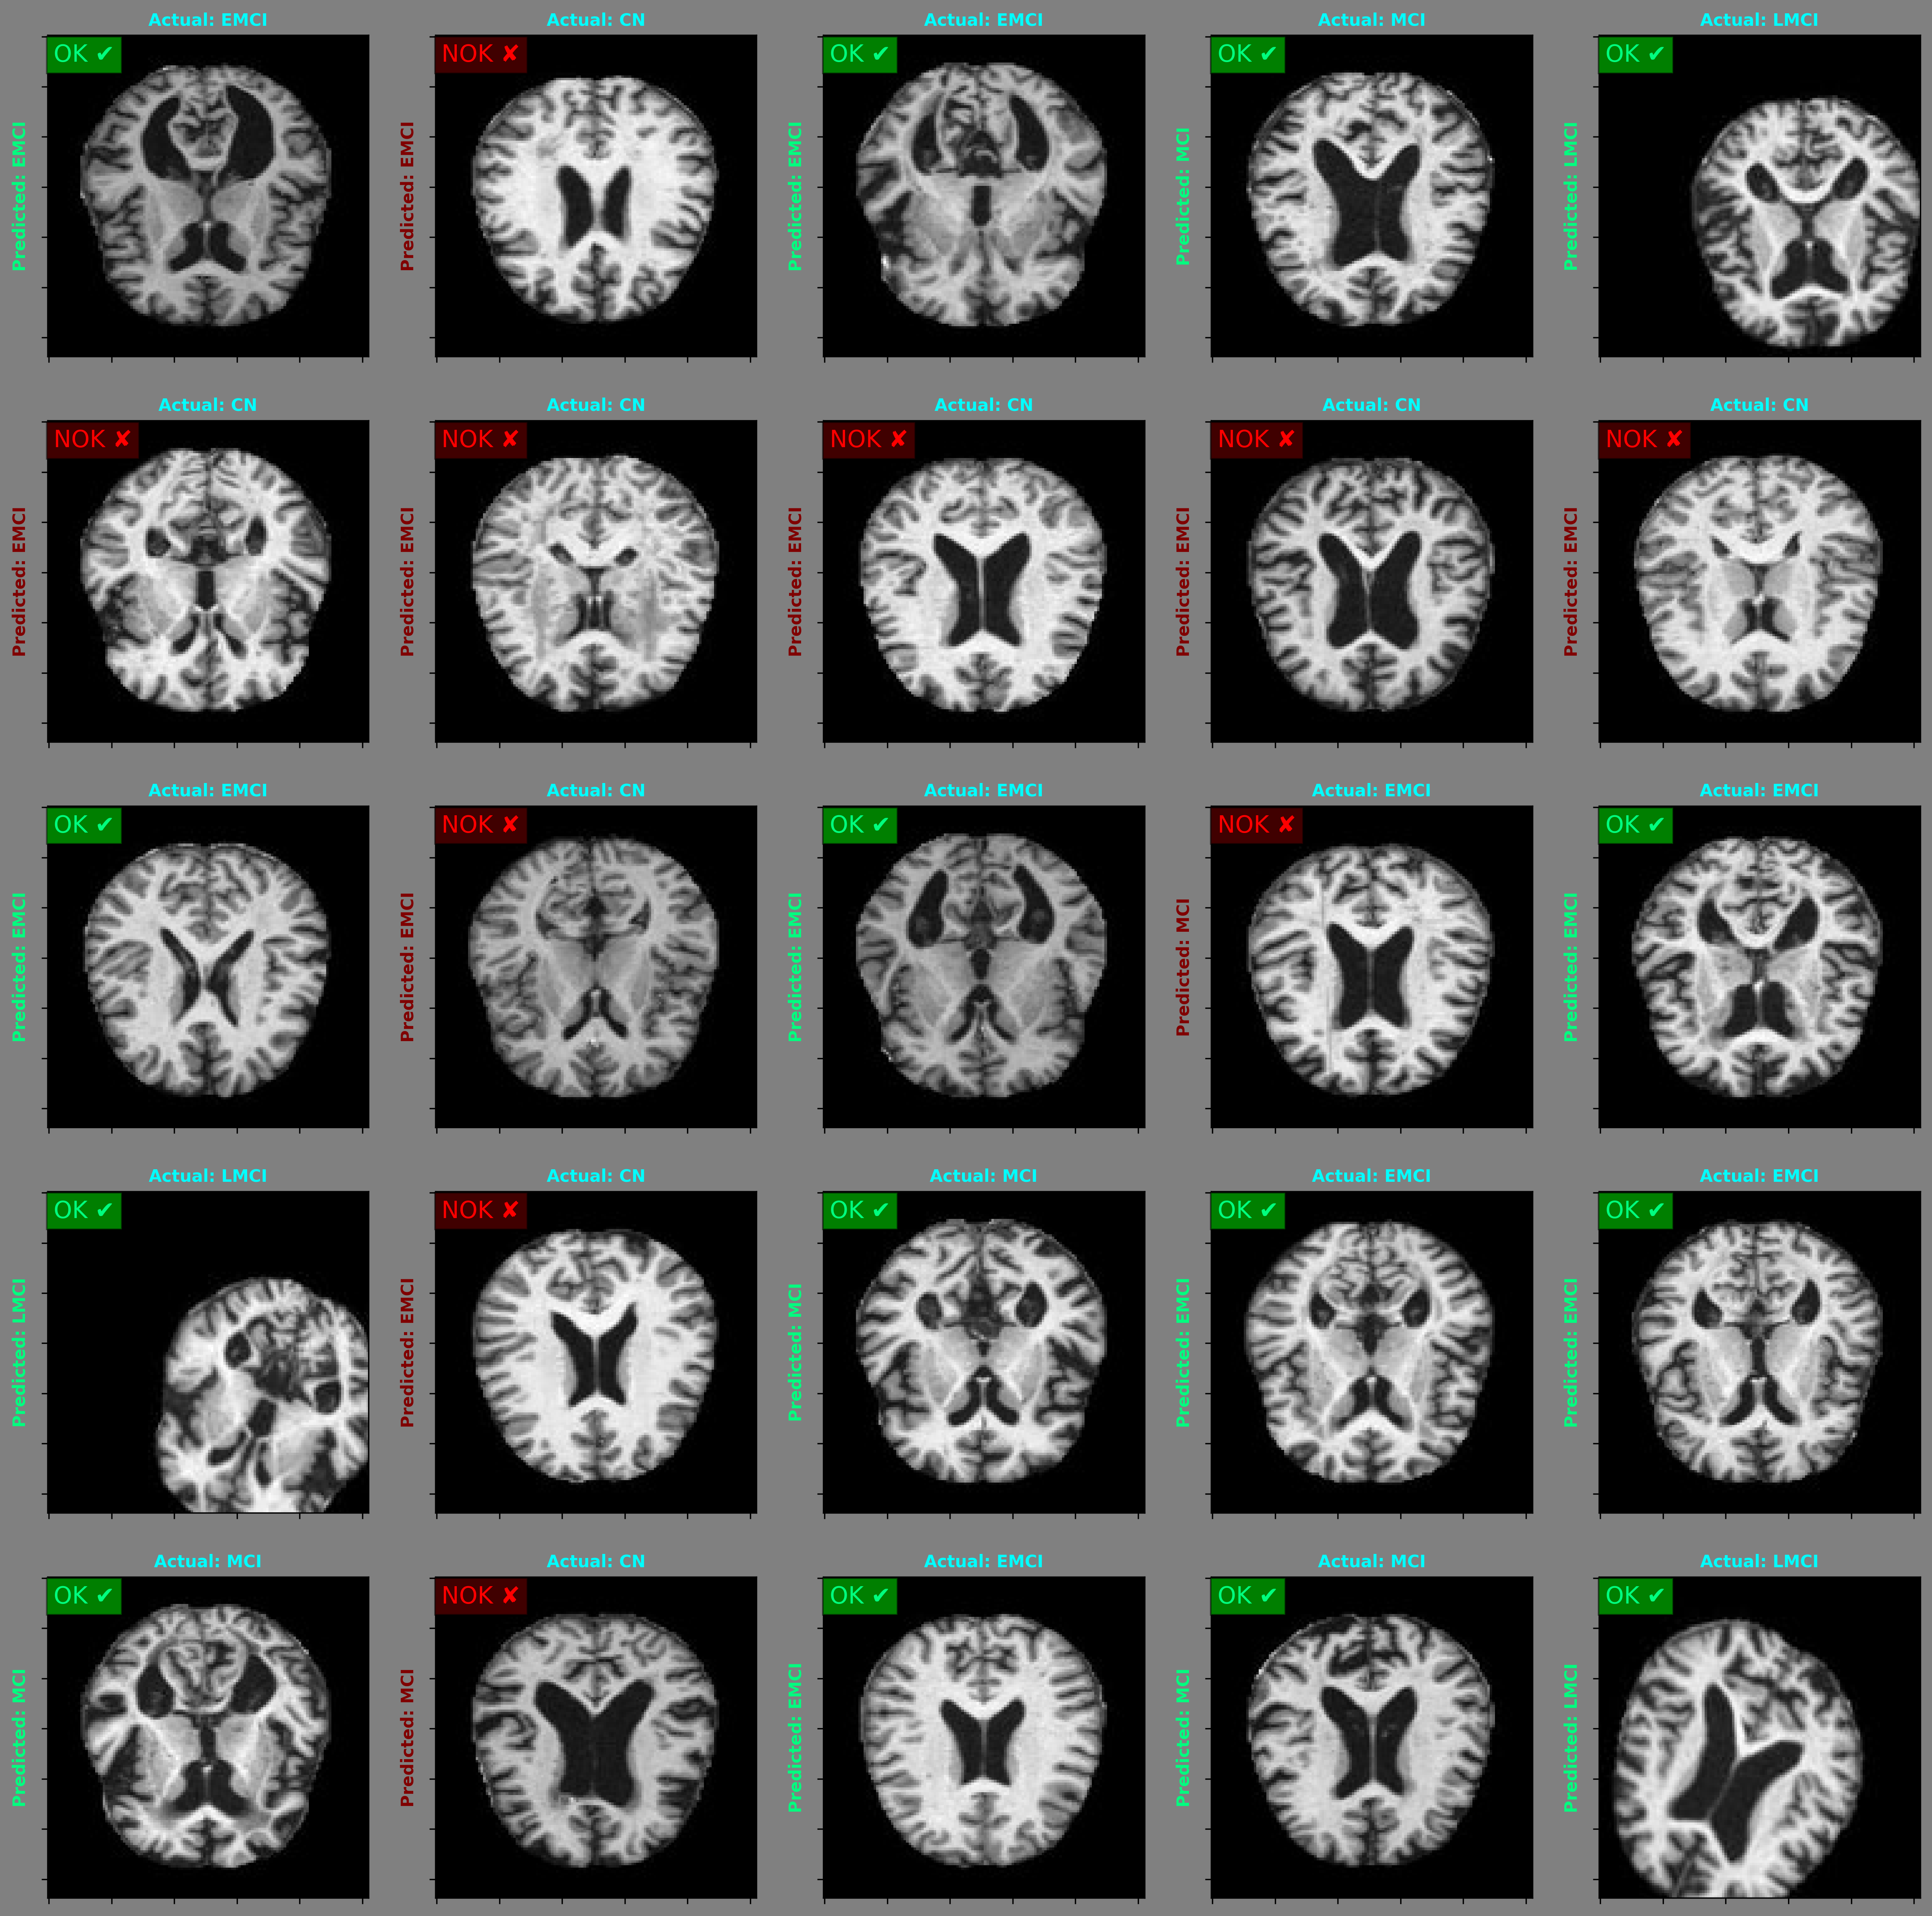

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = vgg_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

# Model Building MobileNet and Testing

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNet

def build_mobilenet_model():
    input_tensor = layers.Input(shape=(128, 128, 3))

    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    output_tensor = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_tensor)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = build_mobilenet_model()

17225924/17225924 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                            

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.5522
Epoch 1: val_accuracy improved from -inf to 0.60085, saving model to /tmp/checkpoint
182/182 [==============================] - 45s 224ms/step - loss: 0.8719 - accuracy: 0.5522 - val_loss: 0.9164 - val_accuracy: 0.6009
Epoch 2/20
182/182 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.6264
Epoch 2: val_accuracy did not improve from 0.60085
182/182 [==============================] - 38s 204ms/step - loss: 0.6893 - accuracy: 0.6264 - val_loss: 0.9552 - val_accuracy: 0.5483
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.6690
Epoch 3: val_accuracy improved from 0.60085 to 0.68324, saving model to /tmp/checkpoint
182/182 [==============================] - 45s 246ms/step - loss: 0.6206 - accuracy: 0.6690 - val_loss: 0.7084 - val_accuracy: 0.6832
Epoch 4/20
182/182 [==============================] - ETA: 0s - loss: 0.5675 - accurac

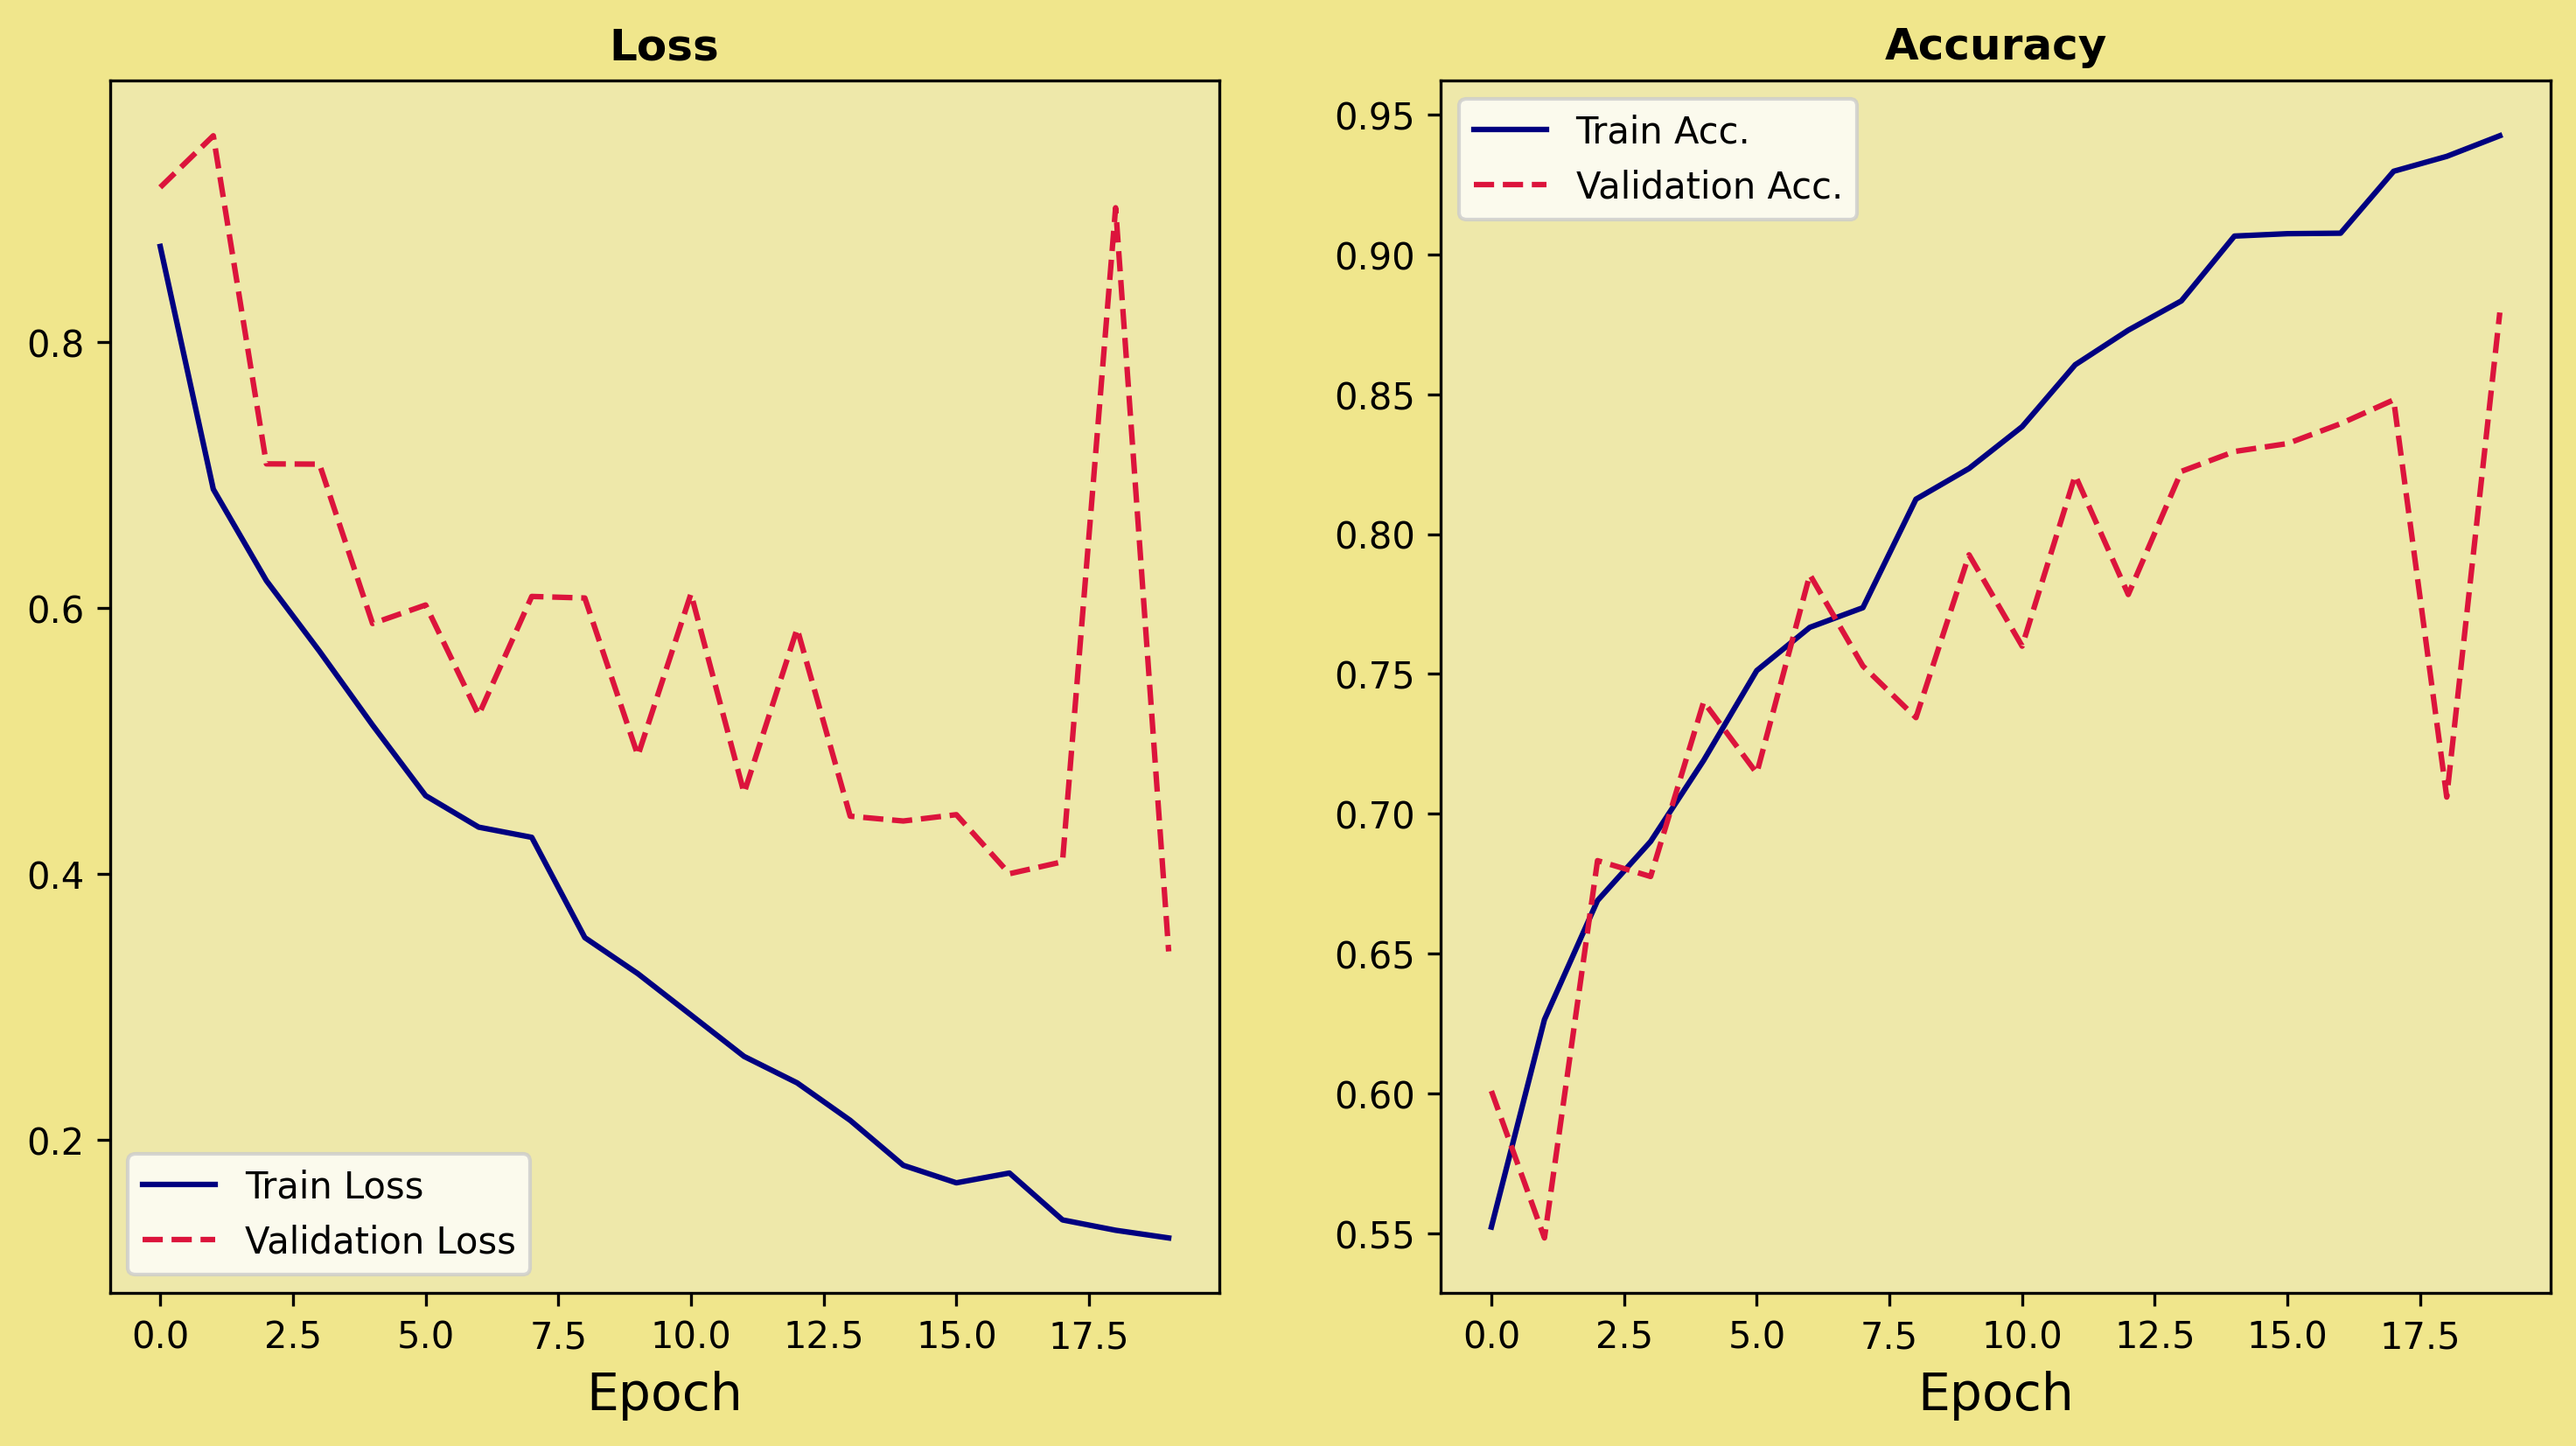

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Capstone', 'mobile_model.h5'))
print("Model saved successfully after training!")

Model saved successfully after training!


In [ ]:
saved_model_path = '/content/drive/MyDrive/Capstone/mobile_model.h5'
mobile_model = load_model(saved_model_path)

In [ ]:
mobile_model.evaluate(test_data)

22/22 [==============================] - 20s 83ms/step - loss: 0.4892 - accuracy: 0.8395


[0.48923197388648987, 0.8394886255264282]

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = mobile_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

          CN       0.89      0.81      0.84       308
        EMCI       0.75      0.79      0.77       215
        LMCI       0.98      1.00      0.99        96
         MCI       0.77      0.89      0.83        85

    accuracy                           0.84       704
   macro avg       0.85      0.87      0.86       704
weighted avg       0.84      0.84      0.84       704



Text(287.16666666666663, 0.5, 'True')

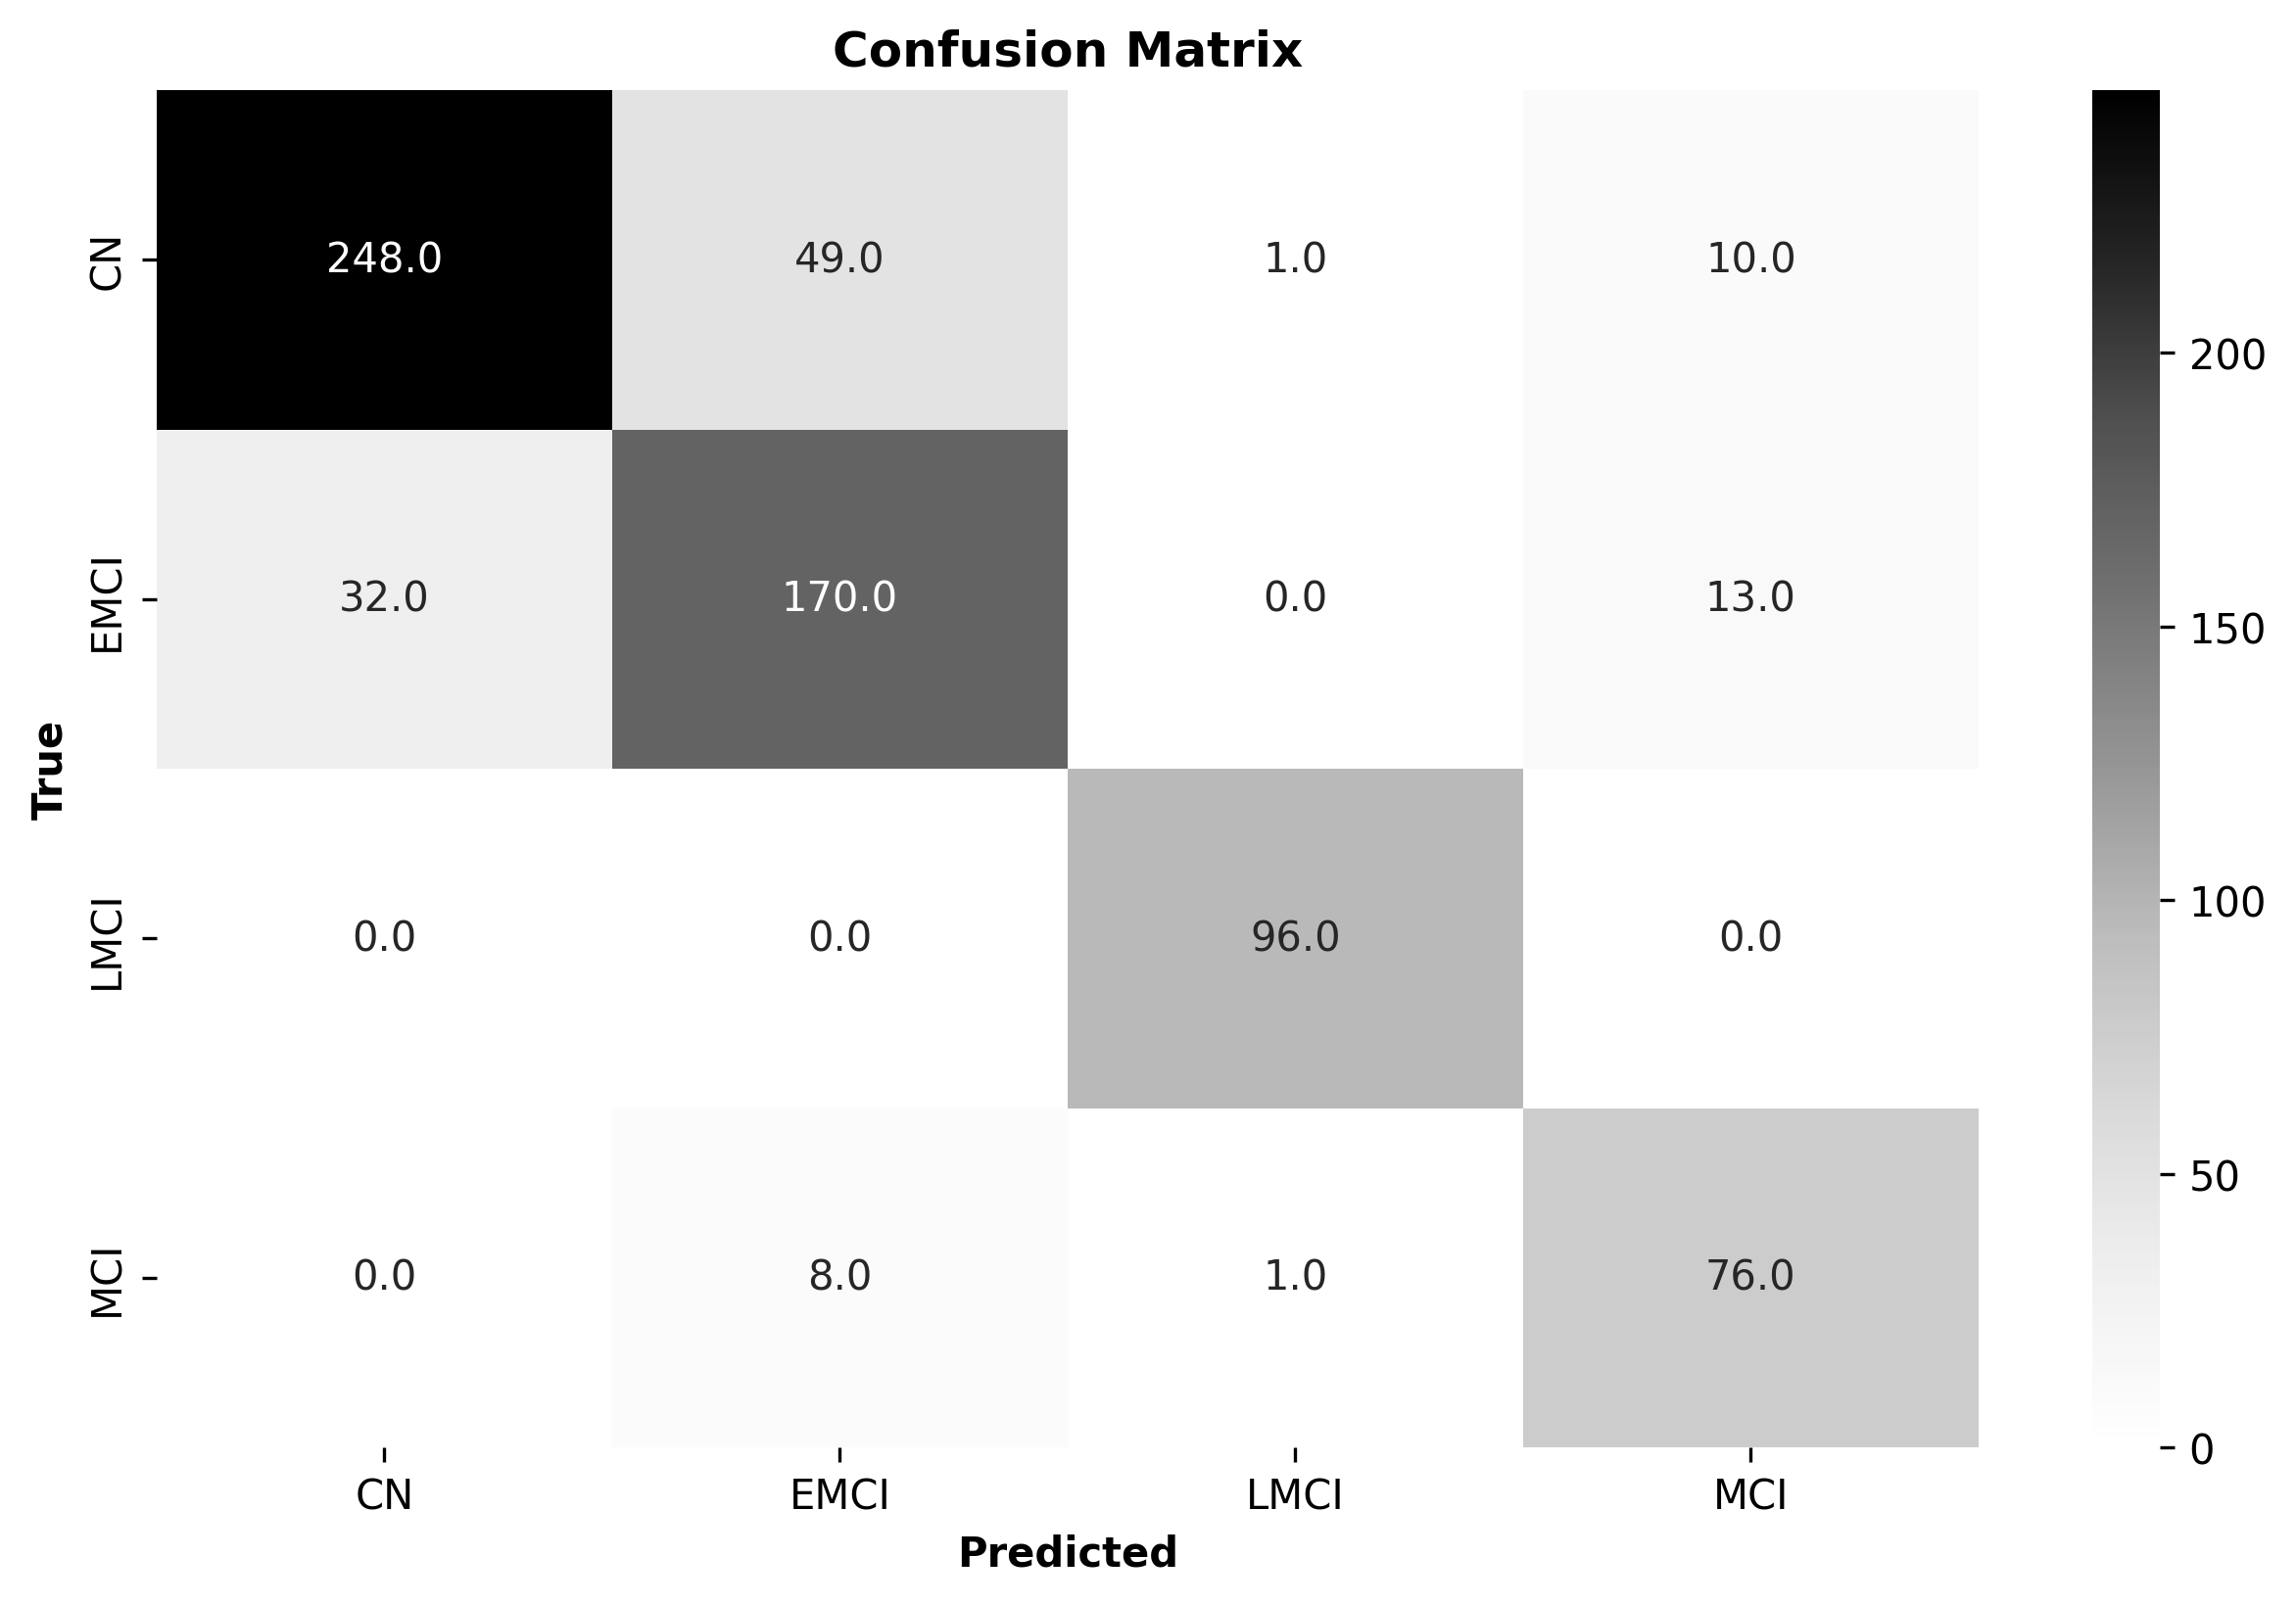

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

1/1 [==============================] - 1s 924ms/step


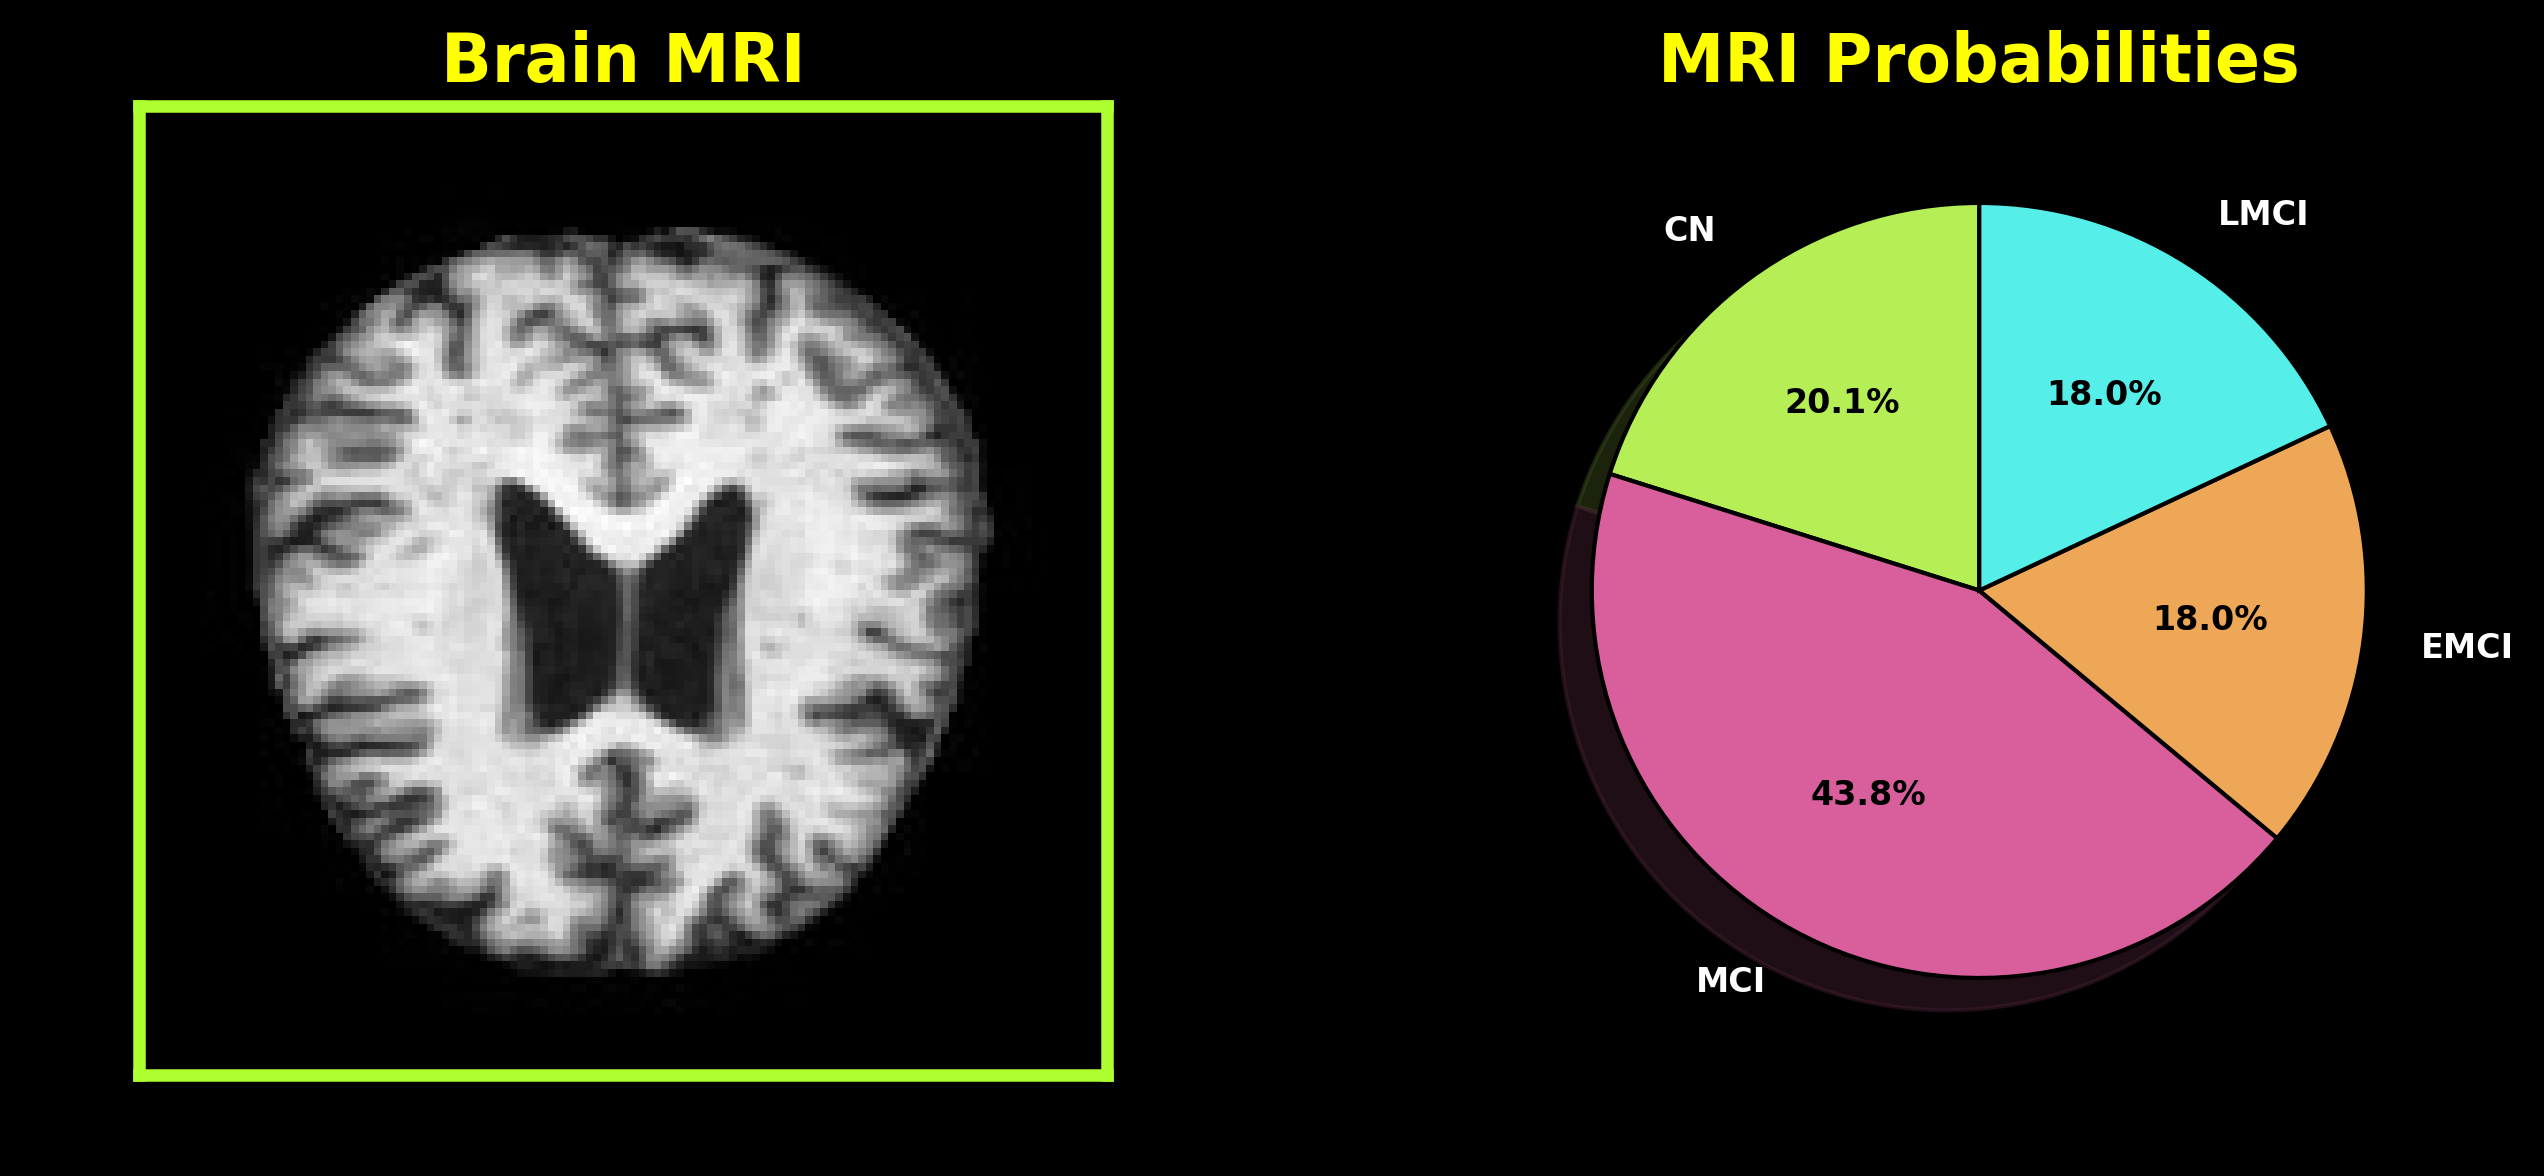

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = mobile_model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('MRI Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

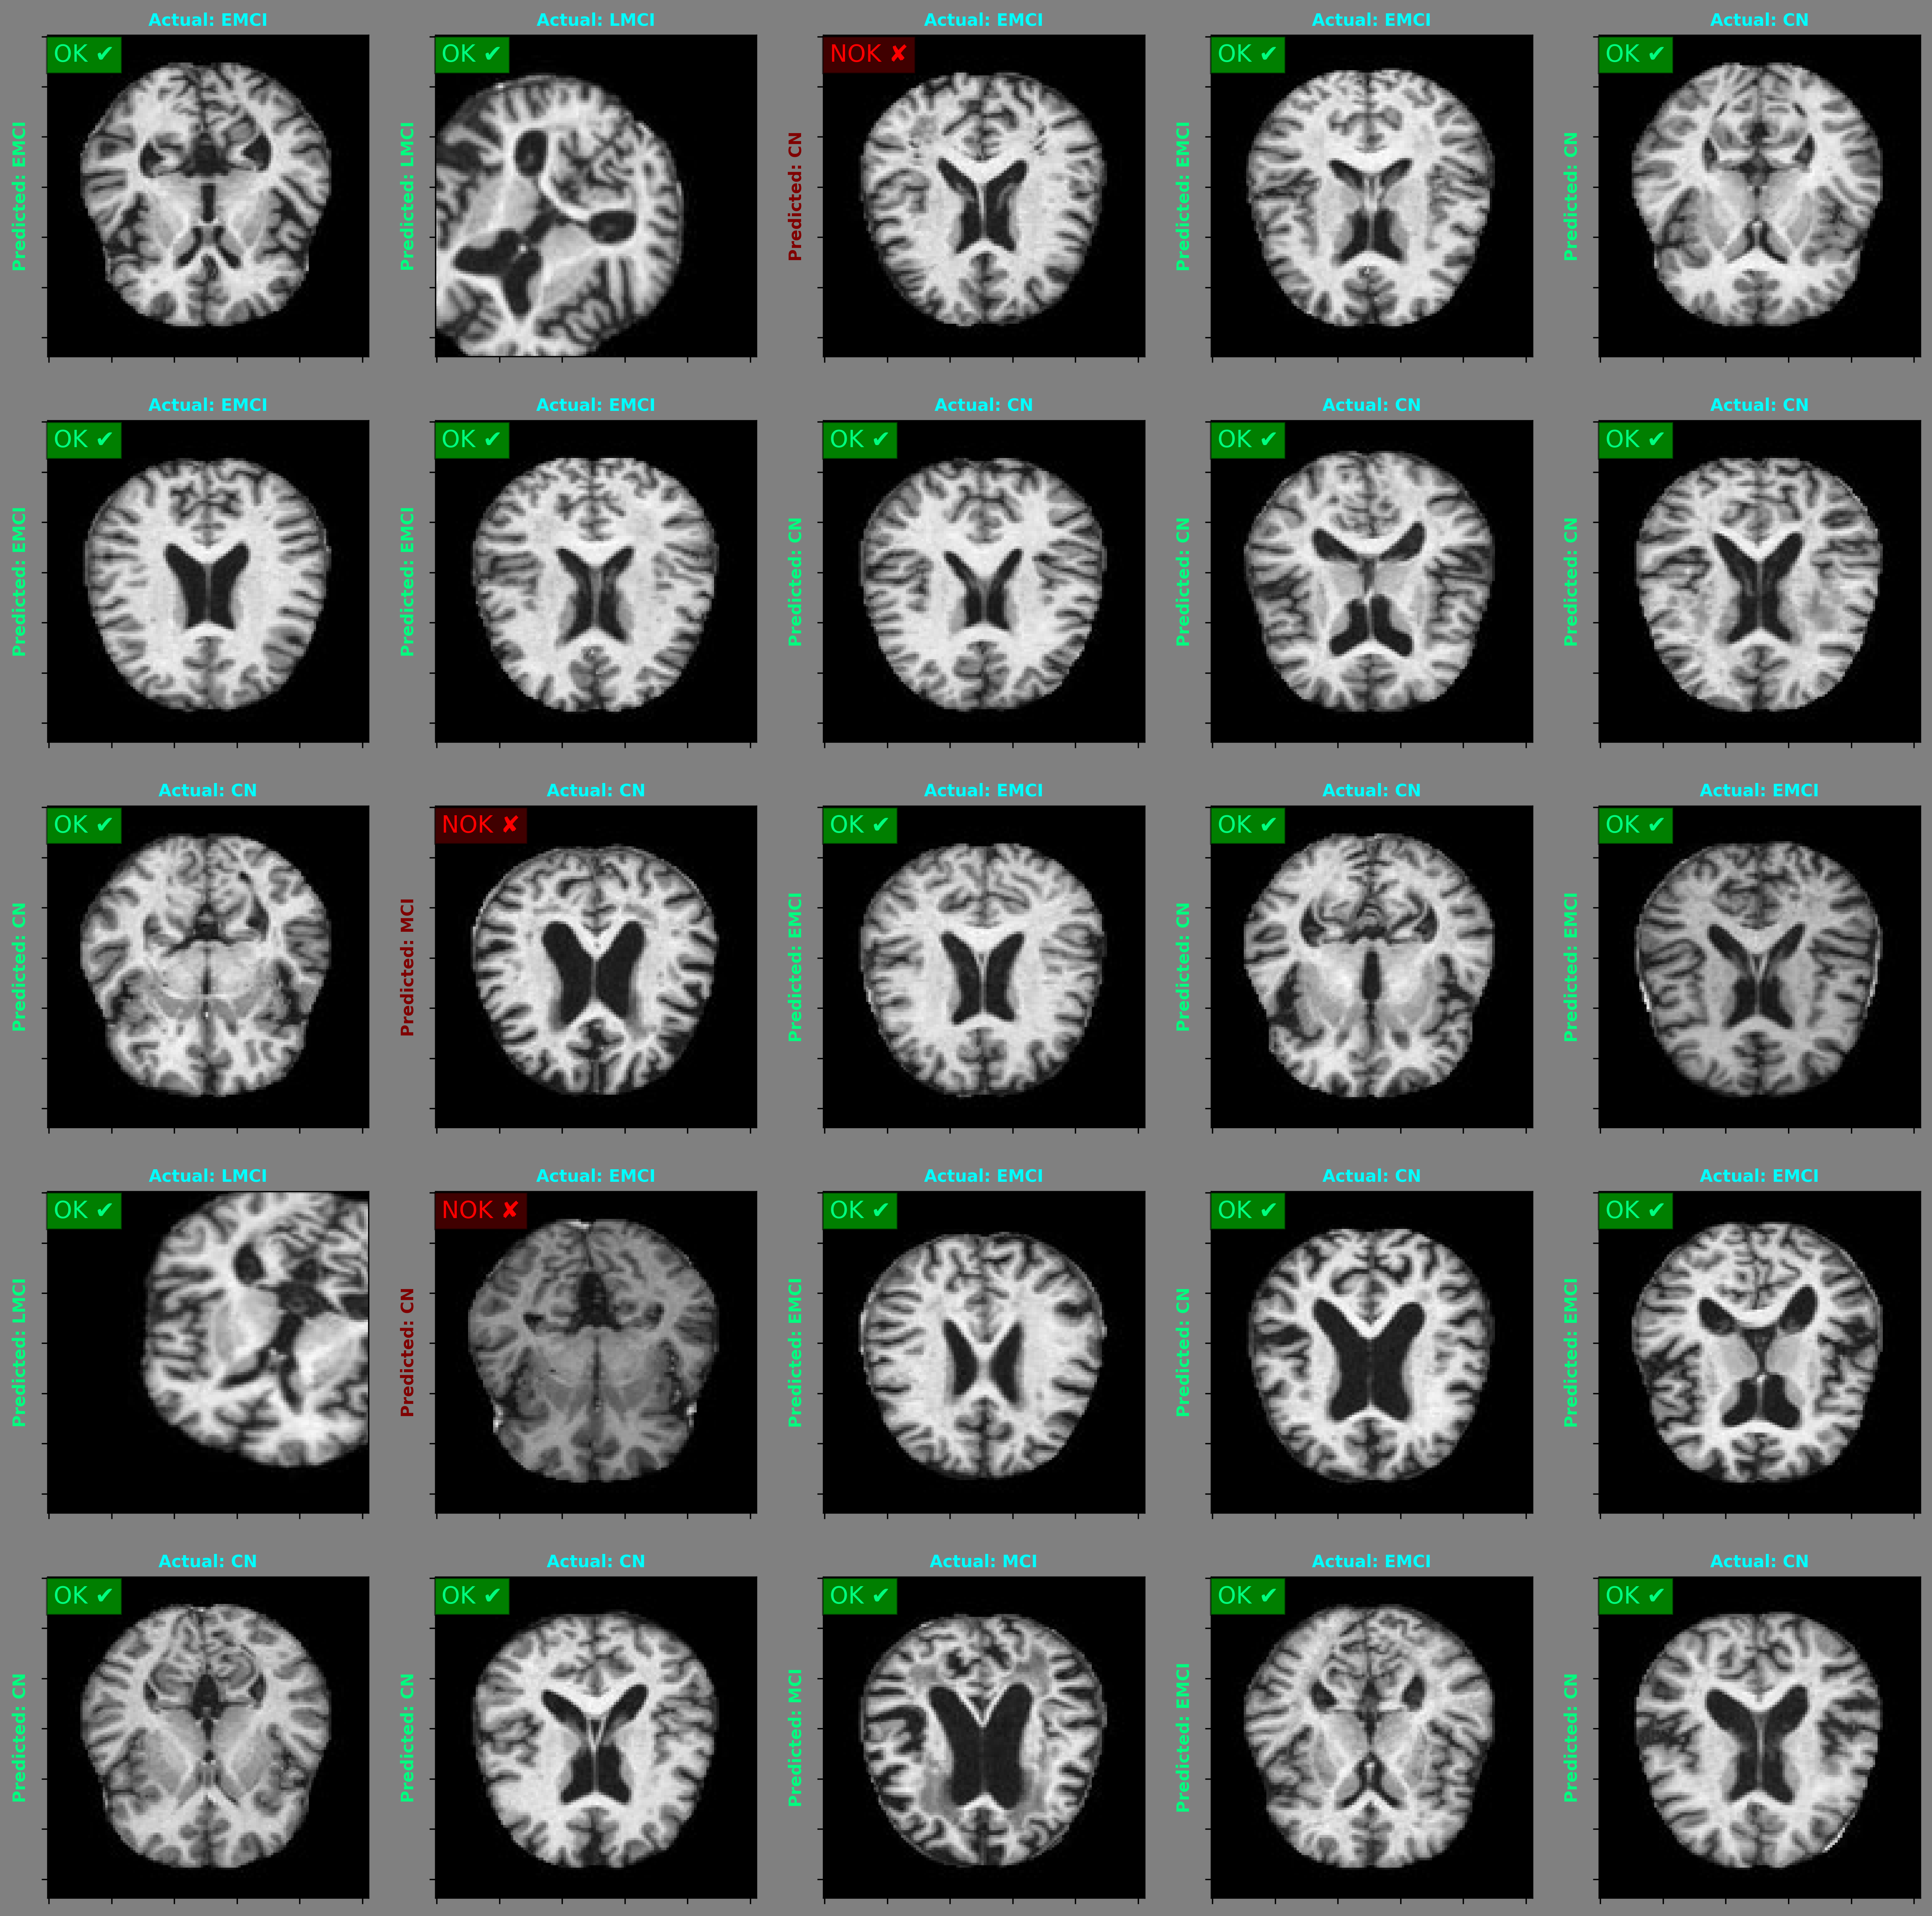

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = mobile_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

# Model Building Inception V3 and Testing

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3

def build_inception_model():
    input_tensor = layers.Input(shape=(128, 128, 3))

    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    output_tensor = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_tensor)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = build_inception_model()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 63, 63, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d_15[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation_6 (Activation) 

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights, callbacks = callbacks)

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 0.9653 - accuracy: 0.5213
Epoch 1: val_accuracy improved from -inf to 0.54688, saving model to /tmp/checkpoint
182/182 [==============================] - 73s 355ms/step - loss: 0.9653 - accuracy: 0.5213 - val_loss: 0.9746 - val_accuracy: 0.5469
Epoch 2/20
182/182 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.6023
Epoch 2: val_accuracy did not improve from 0.54688
182/182 [==============================] - 39s 211ms/step - loss: 0.7662 - accuracy: 0.6023 - val_loss: 1.0068 - val_accuracy: 0.4872
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.7205 - accuracy: 0.6157
Epoch 3: val_accuracy did not improve from 0.54688
182/182 [==============================] - 39s 211ms/step - loss: 0.7205 - accuracy: 0.6157 - val_loss: 1.0306 - val_accuracy: 0.5043
Epoch 4/20
182/182 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.6430
Epoch 4: val_accuracy impro

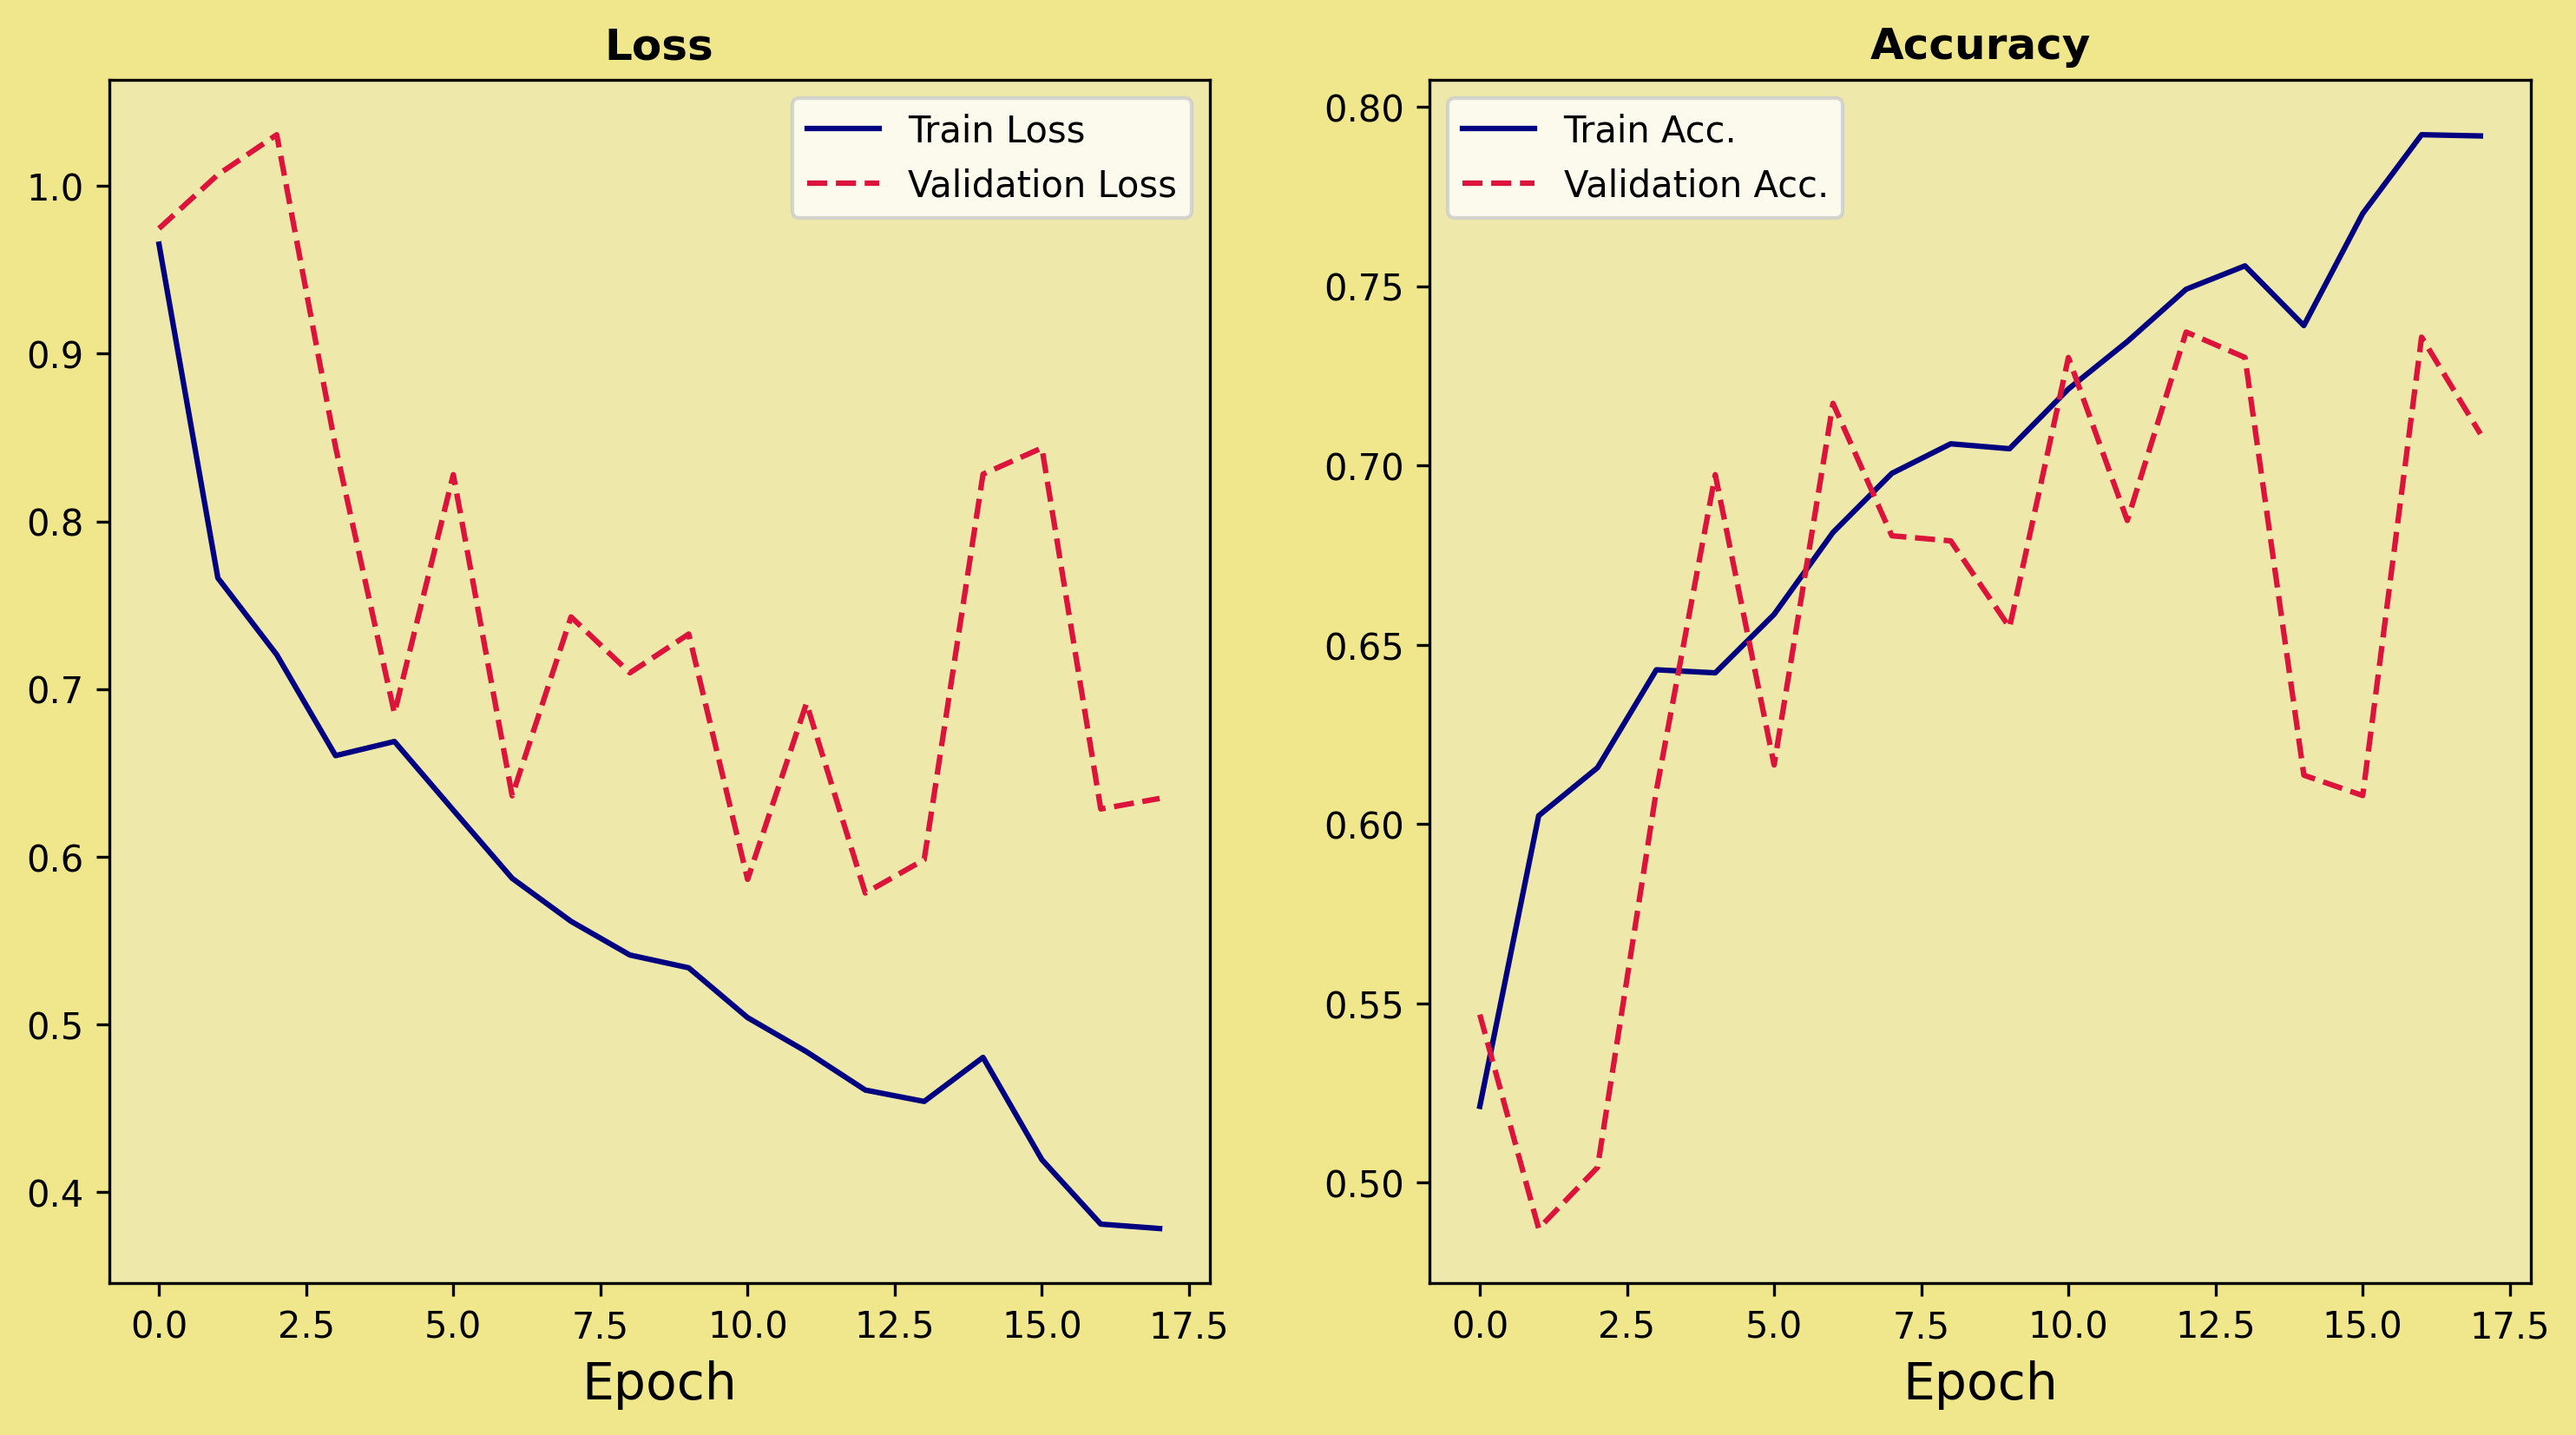

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/Capstone', 'inception_model.h5'))
print("Model saved successfully after training!")

Model saved successfully after training!


In [ ]:
saved_model_path = '/content/drive/MyDrive/Capstone/inception_model.h5'
inception_model = load_model(saved_model_path)

In [ ]:
inception_model.evaluate(test_data)

22/22 [==============================] - 20s 81ms/step - loss: 0.7024 - accuracy: 0.7031


[0.7024259567260742, 0.703125]

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = inception_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

          CN       0.83      0.70      0.76       303
        EMCI       0.65      0.54      0.59       223
        LMCI       0.93      0.99      0.96        89
         MCI       0.47      0.88      0.61        89

    accuracy                           0.71       704
   macro avg       0.72      0.78      0.73       704
weighted avg       0.74      0.71      0.71       704



Text(287.16666666666663, 0.5, 'True')

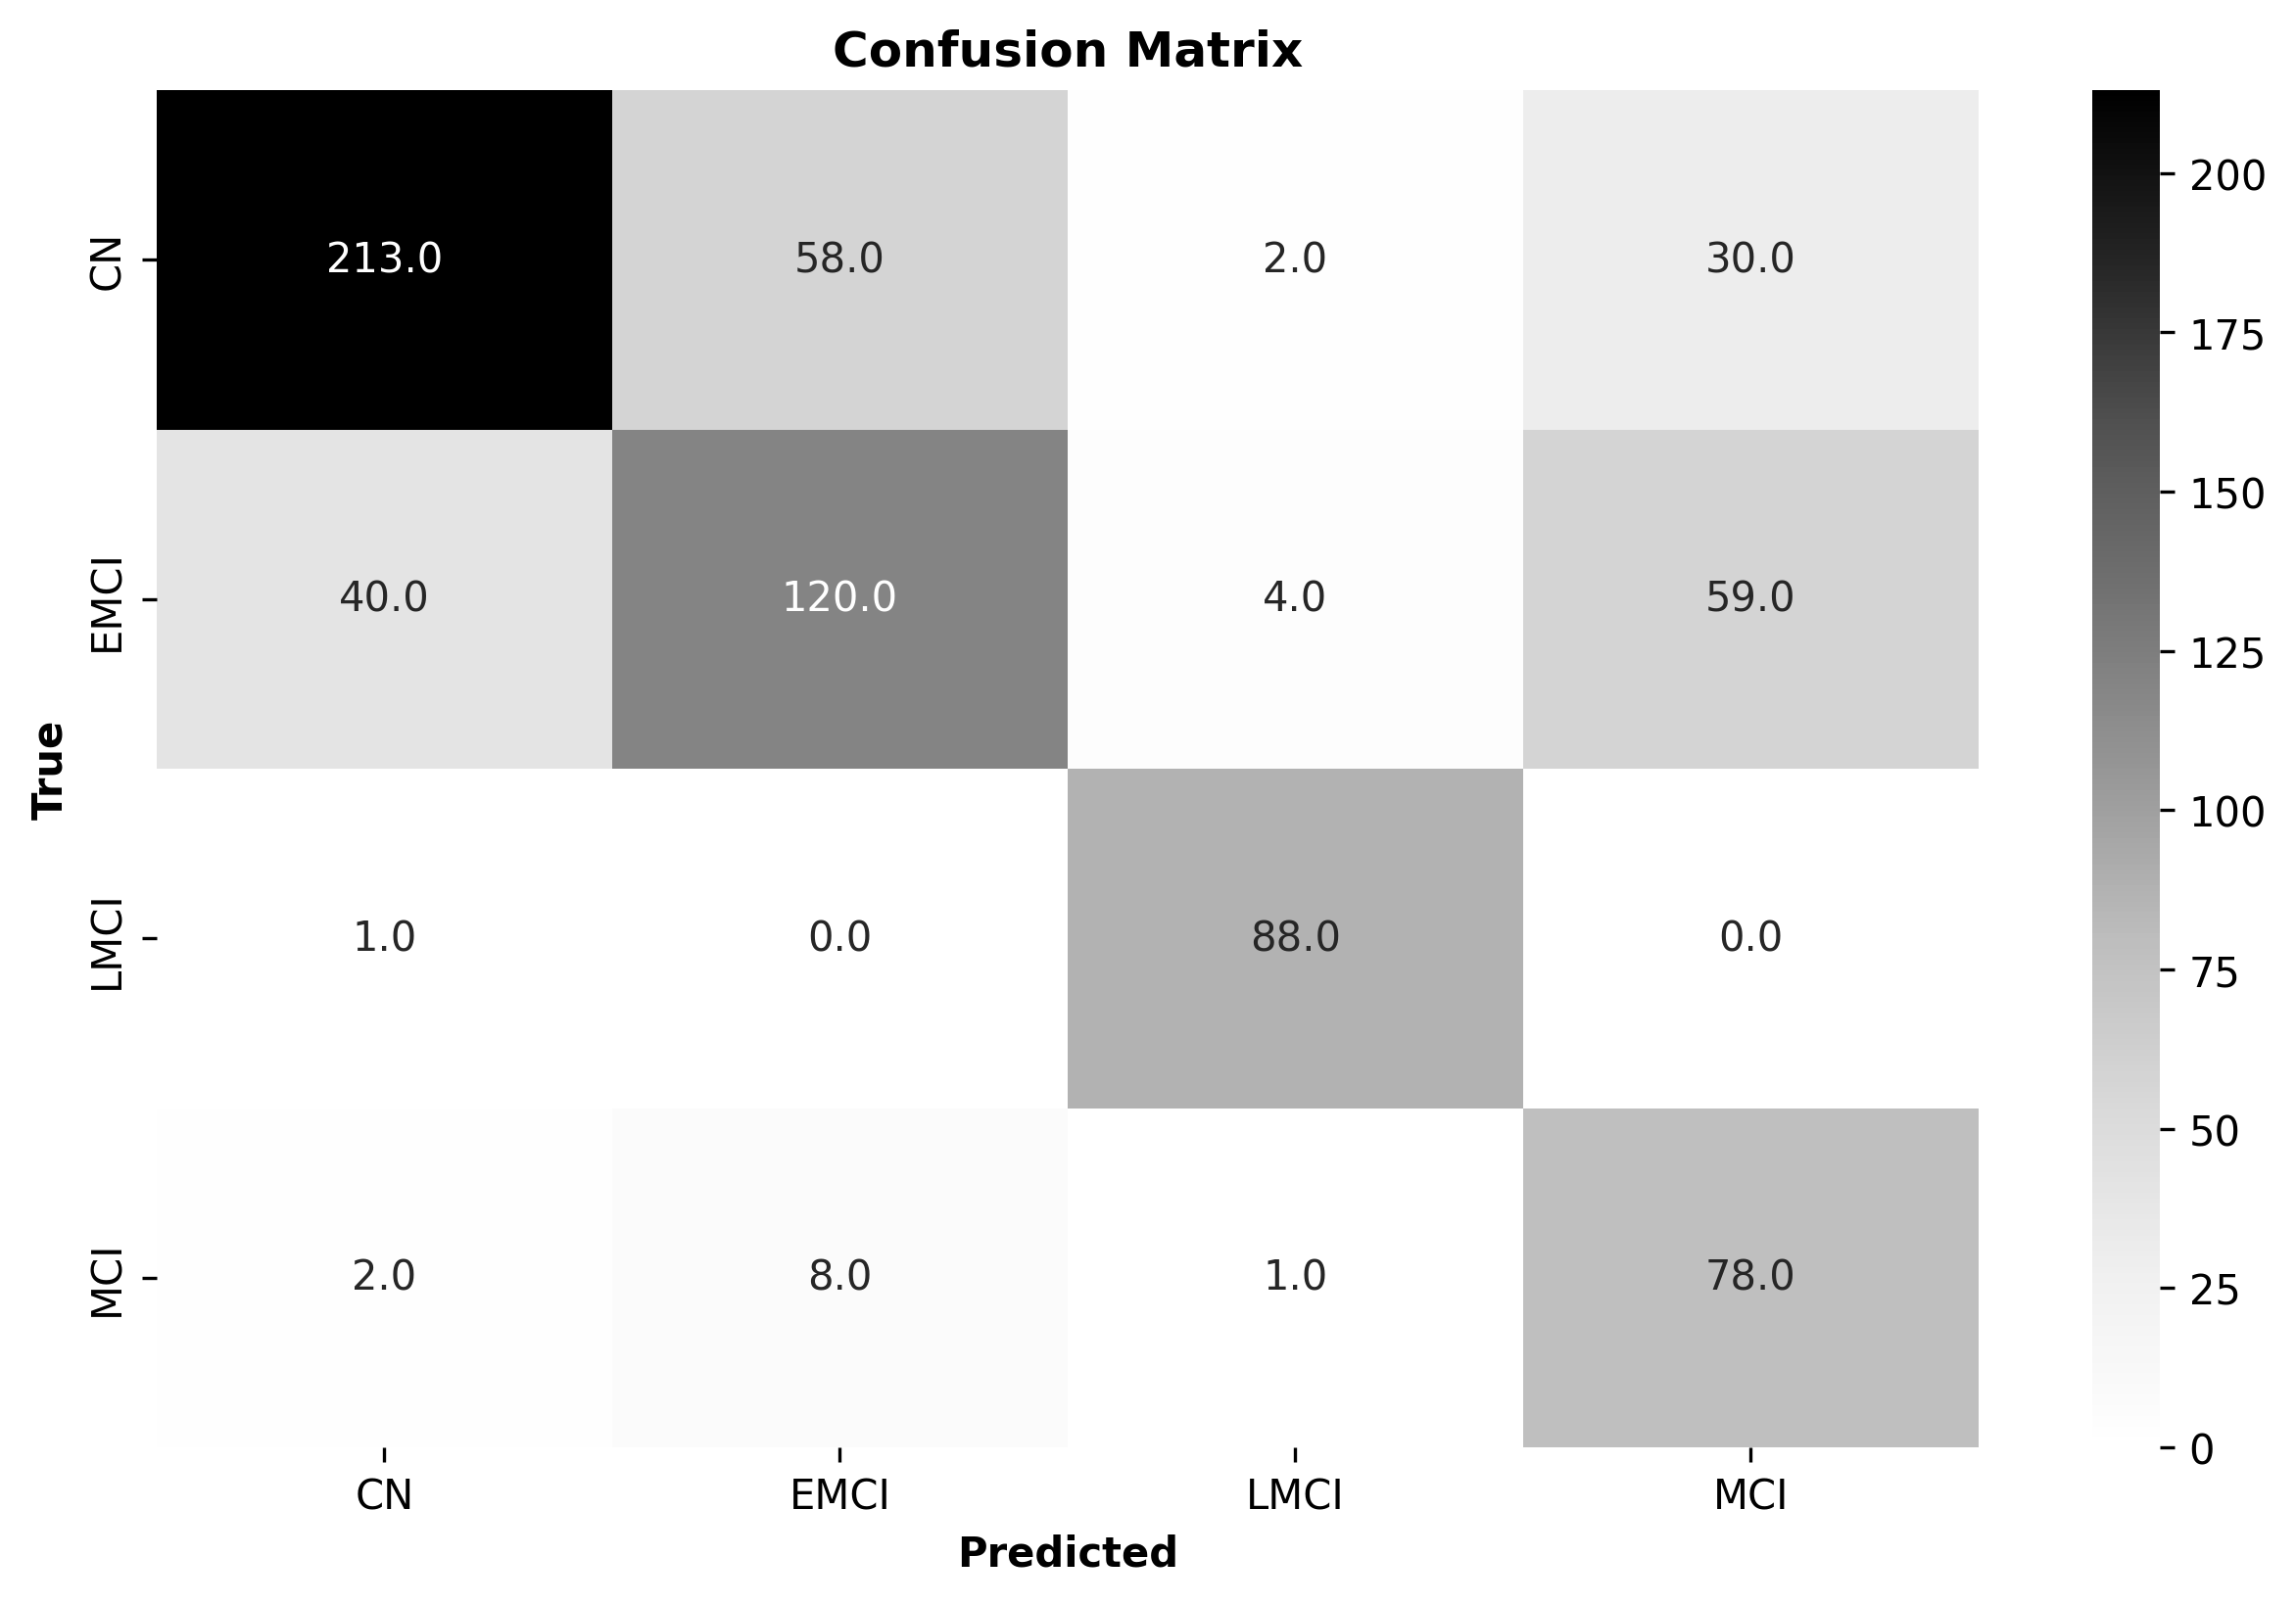

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

1/1 [==============================] - 3s 3s/step


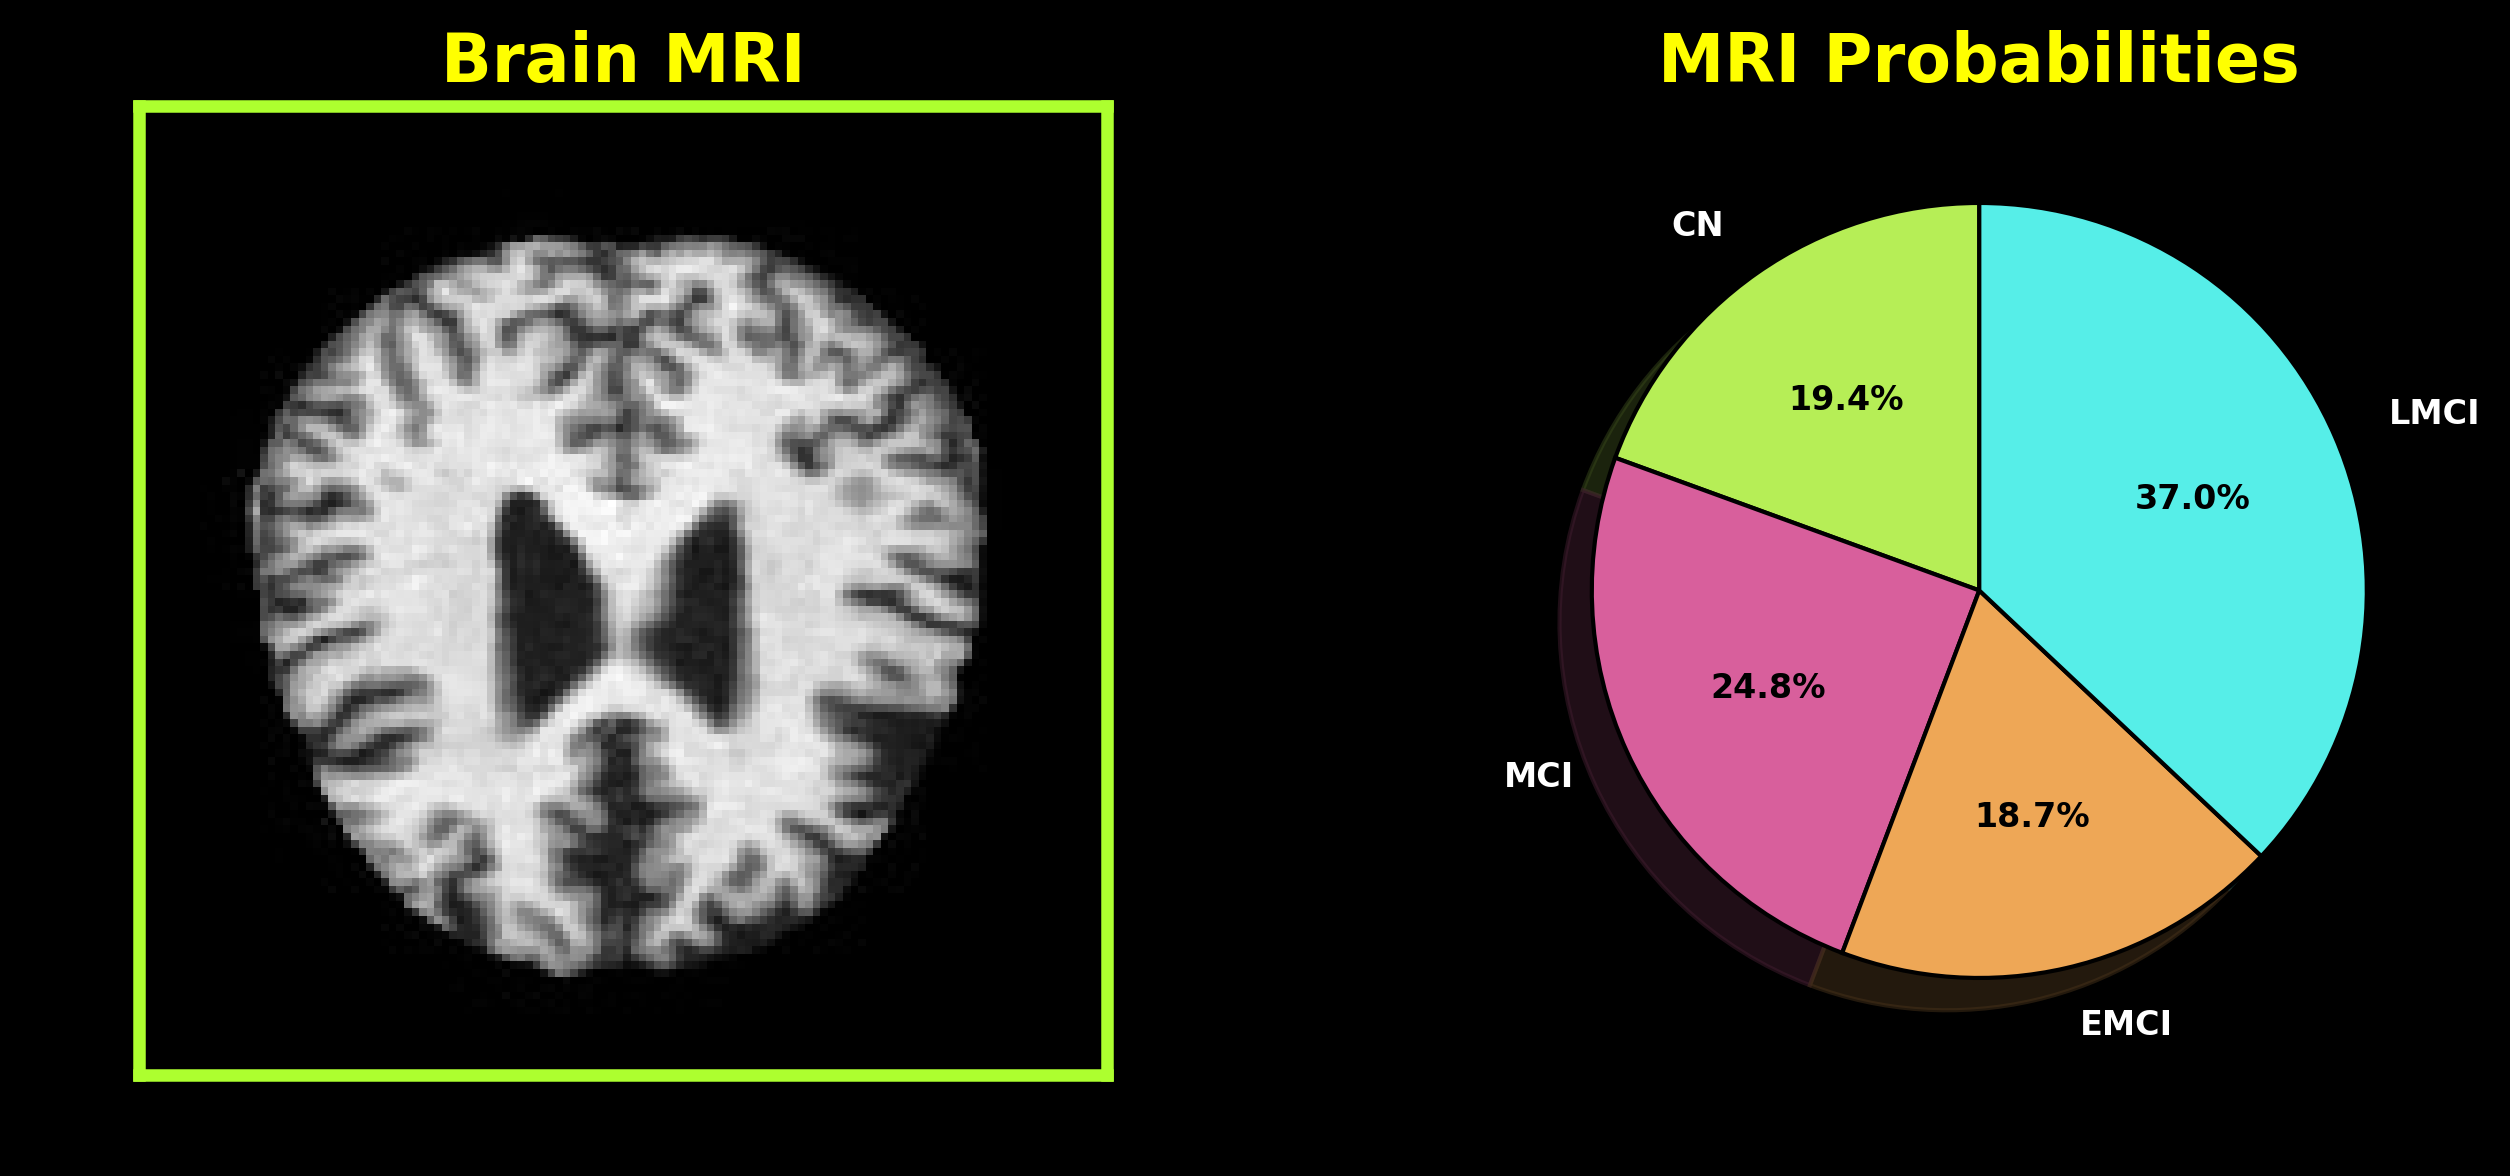

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
def random_mri_prob_bringer(image_number=0):

    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = inception_model.predict(tf.expand_dims(image, 0))[0]

    probs = list(tf.nn.softmax(pred).numpy())
    probs_dict = dict(zip(class_dist.keys(), probs))

    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4)
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)

    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('MRI Probabilities', color="yellow", fontweight="bold", fontsize=16)

rand_img_no = np.random.randint(1, 32)
random_mri_prob_bringer(image_number=rand_img_no)

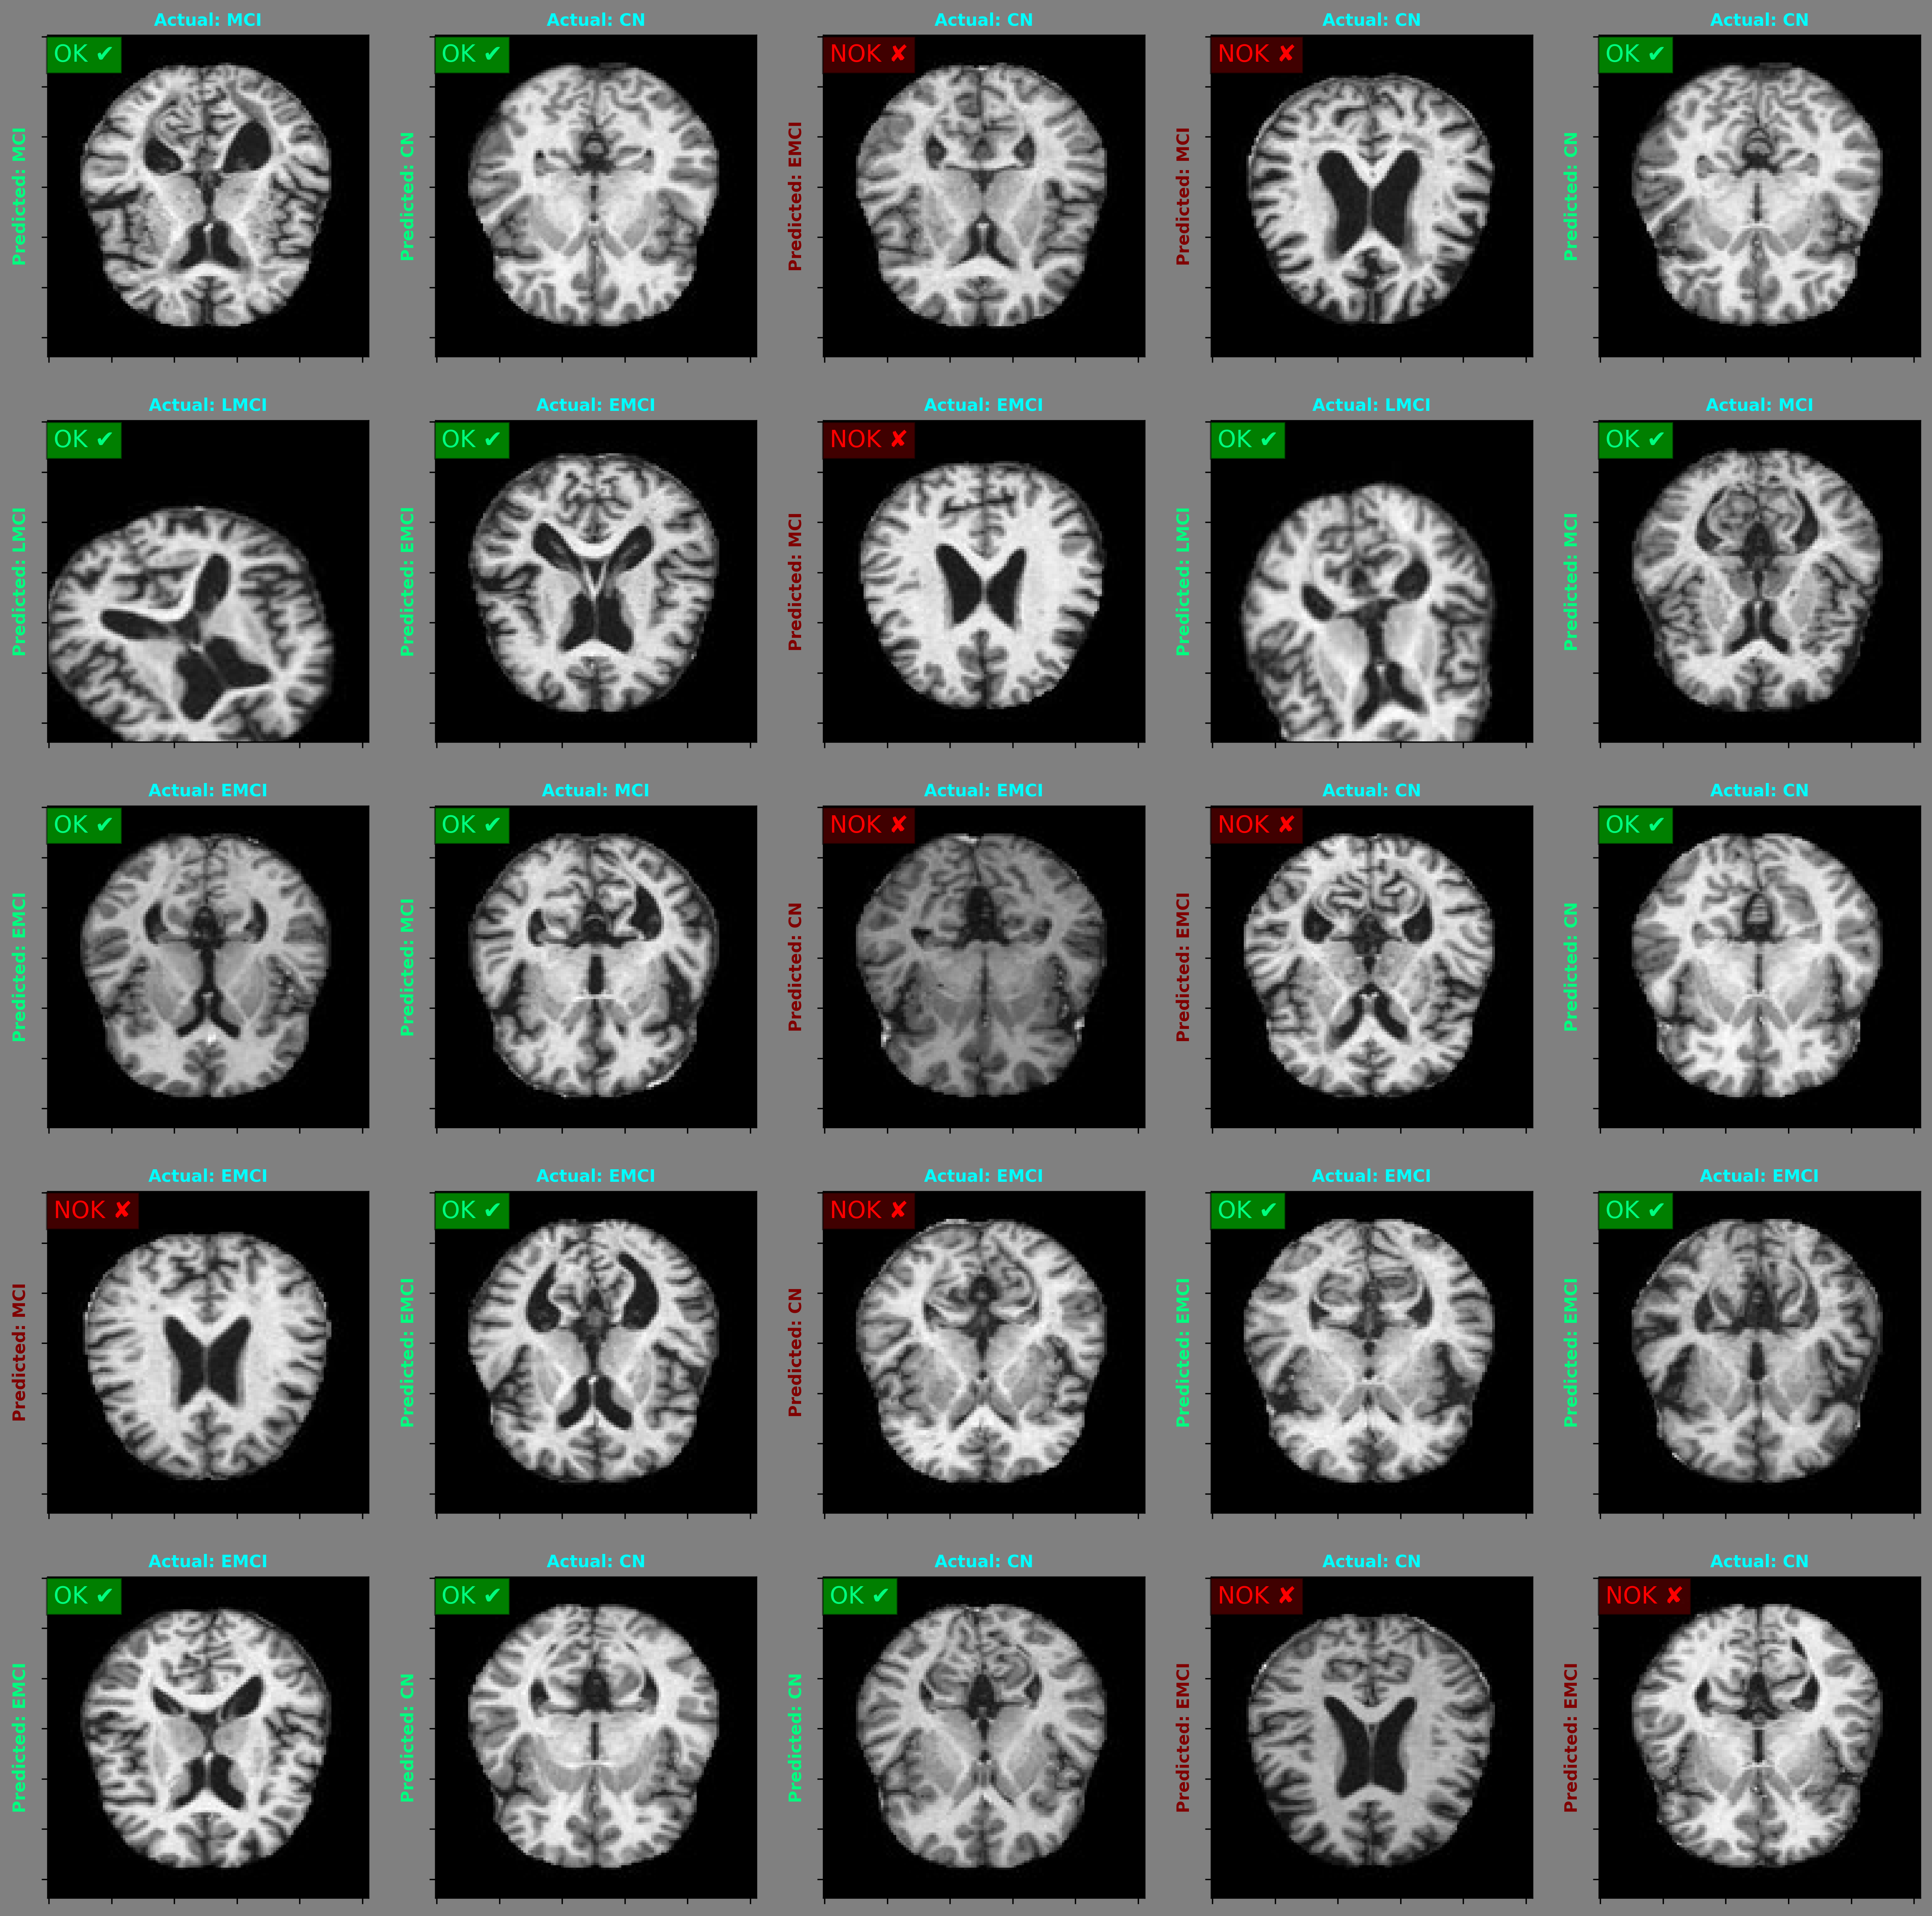

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = inception_model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])